#### Colab setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd "gdrive/My Drive/Colab Notebooks"

#### Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from ipywidgets import IntSlider, interact, fixed

In [3]:
import common
import helpers
import processing.prune as prune
import processing.statistics as statistics
from architecture.models import LeNet_300_100, Conv4
from processing.snapshots import Snapshots
from data import get_mnist, get_cifar
from experiment import Experiment

In [4]:
#np.random.seed(common.SEED)
#torch.manual_seed(common.SEED)

In [5]:
pruning_methods = [prune.max_fp_pruning, prune.min_fp_pruning, prune.max_ip_pruning, prune.min_ip_pruning, prune.max_fp_mod_pruning, prune.min_fp_mod_pruning, prune.max_mag_pruning, prune.min_mag_pruning]

In [6]:
def load_state_dict(model_name):
    model_fname = os.path.join(common.MODEL_PATH, model_name)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    return torch.load(model_fname, map_location=device)

In [7]:
def length_mag_plot(plot_data, thresholds, idx):
    fig = plt.figure(figsize=(12,7))
    x, y = plot_data[idx]
    plt.scatter(x, y)
    plt.title("Length vs max magnitude for cut-off {:.3f} ({} connected components)".format(thresholds[idx], len(x)))
    plt.xlabel("Connected component length")
    plt.ylabel("Max magnitude of node in connected component")

In [8]:
def compare_pruning(experiment, testloader, layer, n_rounds, pruning_ratio, *, include_random=False, save_results=False):
    if include_random:
        print("Random pruning experiment:\n")
        exp_acc, exp_fps = prune.random_pruning_rounds(experiment, testloader, layer, n_rounds, 
                                               pruning_ratio, save_results=save_results)
    else:
        exp_acc = []
        exp_fps = []
    
    pruning_accuracies = {}
    pruning_fps = {}
    for pruning in pruning_methods:
        pruning_method = pruning.__name__
        print("Pruning using:", pruning_method)
        experiment.init_model()
        acc, fps = prune.prune_and_test(experiment, testloader, layer, pruning, 
                                         pruning_ratio, save_results=False)
        pruning_accuracies[pruning_method] = acc
        pruning_fps[pruning_method] = fps
        
    if save_results:
        prune.save_pruning_meta(experiment.model, layer, "combined", pruning_ratio, pruning_accuracies, pruning_fps)
    
    return exp_acc, exp_fps, pruning_accuracies, pruning_fps

In [9]:
def mnist_pruning(testloader, layers, *, model_name="LeNet_300_100_01-10-2019_10:13:45", pruning_ratio=0.9, include_random=False, n_rounds=0, save_results=True):
    optim_kwargs = {'lr': 0.003, 'momentum': 0.9}
    model = LeNet_300_100()
    model_state = load_state_dict(model_name)
    model.load_state_dict(model_state)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), **optim_kwargs)
    e = Experiment(model, criterion, optimizer, optim_kwargs, model_state=model_state)
    for layer in layers:
        exp_acc, exp_fps, pruning_accuracies, pruning_fps = compare_pruning(e, testloader, layer, n_rounds, pruning_ratio, include_random=include_random, save_results=save_results)
    
    return exp_acc, exp_fps, pruning_accuracies, pruning_fps

In [10]:
def cifar_pruning(testloader, layers, *, model_name="Conv2_01-10-2019_12:37:35", pruning_ratio=0.9, include_random=False, n_rounds=0, save_results=True):
    optim_kwargs = {'lr': 0.0002}
    model = Conv2()
    model_state = load_state_dict(model_name)
    model.load_state_dict(model_state)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), **optim_kwargs)
    e = Experiment(model, criterion, optimizer, optim_kwargs, model_state=model_state)
    for layer in layers:
        exp_acc, exp_fps, pruning_accuracies, pruning_fps = compare_pruning(e, testloader, layer, n_rounds, pruning_ratio, include_random=include_random, save_results=save_results)
    
    return exp_acc, exp_fps, pruning_accuracies, pruning_fps

In [11]:
def cifar_scheduling(testloader, layers, pruning, pruning_ratios, *, epochs=5, test_interval=50, saving_times=[1, 8, 40], save_results=True):
    for pruning_ratio in pruning_ratios:
        optim_kwargs = {'lr': 0.0002}
        model = Conv2()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), **optim_kwargs)
        e = Experiment(model, criterion, optimizer, optim_kwargs)
        accuracies, frame_potentials = prune.pruning_schedule(e, trainloader, testloader, epochs, test_interval, saving_times, layers, pruning, pruning_ratio, save_results=save_results)
    return accuracies, frame_potentials

## MNIST / Lenet 300-100-10

### Loading the data

In [12]:
train_batch_size = 16
test_batch_size = 1000

In [13]:
trainloader, testloader, classes = get_mnist(train_batch_size, test_batch_size)

### Training the model

In [14]:
epochs = 10
optim_kwargs = {'lr': 0.003, 'momentum': 0.9}

In [15]:
model = LeNet_300_100(bias=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)

In [16]:
test_accuracies = e.fit(trainloader, testloader, epochs, save_results=True)


Test set: Average loss: 2.3078, Accuracy:   1224/ 10000 (12%)

Created model directory: out/LeNet_300_100-unbiased-24_10_2019-11:35:00
Train Epoch:   1 [     0/ 60000 (0%)]	Loss: 2.297339
Train Epoch:   1 [  1600/ 60000 (3%)]	Loss: 0.981066
Train Epoch:   1 [  3200/ 60000 (5%)]	Loss: 0.464690
Train Epoch:   1 [  4800/ 60000 (8%)]	Loss: 0.543019
Train Epoch:   1 [  6400/ 60000 (11%)]	Loss: 0.118098
Train Epoch:   1 [  8000/ 60000 (13%)]	Loss: 0.626859
Train Epoch:   1 [  9600/ 60000 (16%)]	Loss: 0.292227
Train Epoch:   1 [ 11200/ 60000 (19%)]	Loss: 0.844086
Train Epoch:   1 [ 12800/ 60000 (21%)]	Loss: 0.408728
Train Epoch:   1 [ 14400/ 60000 (24%)]	Loss: 0.418998
Train Epoch:   1 [ 16000/ 60000 (27%)]	Loss: 0.150357
Train Epoch:   1 [ 17600/ 60000 (29%)]	Loss: 0.135643
Train Epoch:   1 [ 19200/ 60000 (32%)]	Loss: 0.188149
Train Epoch:   1 [ 20800/ 60000 (35%)]	Loss: 0.062210
Train Epoch:   1 [ 22400/ 60000 (37%)]	Loss: 0.164477
Train Epoch:   1 [ 24000/ 60000 (40%)]	Loss: 0.078838
Trai

Train Epoch:   4 [ 51200/ 60000 (85%)]	Loss: 0.023423
Train Epoch:   4 [ 52800/ 60000 (88%)]	Loss: 0.181666
Train Epoch:   4 [ 54400/ 60000 (91%)]	Loss: 0.010917
Train Epoch:   4 [ 56000/ 60000 (93%)]	Loss: 0.038075
Train Epoch:   4 [ 57600/ 60000 (96%)]	Loss: 0.001806
Train Epoch:   4 [ 59200/ 60000 (99%)]	Loss: 0.006408

Test set: Average loss: 0.0844, Accuracy:   9734/ 10000 (97%)

Train Epoch:   5 [     0/ 60000 (0%)]	Loss: 0.002814
Train Epoch:   5 [  1600/ 60000 (3%)]	Loss: 0.512003
Train Epoch:   5 [  3200/ 60000 (5%)]	Loss: 0.026520
Train Epoch:   5 [  4800/ 60000 (8%)]	Loss: 0.014745
Train Epoch:   5 [  6400/ 60000 (11%)]	Loss: 0.001310
Train Epoch:   5 [  8000/ 60000 (13%)]	Loss: 0.010484
Train Epoch:   5 [  9600/ 60000 (16%)]	Loss: 0.008093
Train Epoch:   5 [ 11200/ 60000 (19%)]	Loss: 0.122102
Train Epoch:   5 [ 12800/ 60000 (21%)]	Loss: 0.013142
Train Epoch:   5 [ 14400/ 60000 (24%)]	Loss: 0.007799
Train Epoch:   5 [ 16000/ 60000 (27%)]	Loss: 0.000806
Train Epoch:   5 [ 176

Train Epoch:   8 [ 44800/ 60000 (75%)]	Loss: 0.000124
Train Epoch:   8 [ 46400/ 60000 (77%)]	Loss: 0.007737
Train Epoch:   8 [ 48000/ 60000 (80%)]	Loss: 0.006459
Train Epoch:   8 [ 49600/ 60000 (83%)]	Loss: 0.000280
Train Epoch:   8 [ 51200/ 60000 (85%)]	Loss: 0.000520
Train Epoch:   8 [ 52800/ 60000 (88%)]	Loss: 0.013046
Train Epoch:   8 [ 54400/ 60000 (91%)]	Loss: 0.000862
Train Epoch:   8 [ 56000/ 60000 (93%)]	Loss: 0.012621
Train Epoch:   8 [ 57600/ 60000 (96%)]	Loss: 0.000270
Train Epoch:   8 [ 59200/ 60000 (99%)]	Loss: 0.010056

Test set: Average loss: 0.0832, Accuracy:   9791/ 10000 (98%)

Train Epoch:   9 [     0/ 60000 (0%)]	Loss: 0.000614
Train Epoch:   9 [  1600/ 60000 (3%)]	Loss: 0.231478
Train Epoch:   9 [  3200/ 60000 (5%)]	Loss: 0.001956
Train Epoch:   9 [  4800/ 60000 (8%)]	Loss: 0.003655
Train Epoch:   9 [  6400/ 60000 (11%)]	Loss: 0.000067
Train Epoch:   9 [  8000/ 60000 (13%)]	Loss: 0.002336
Train Epoch:   9 [  9600/ 60000 (16%)]	Loss: 0.000362
Train Epoch:   9 [ 112

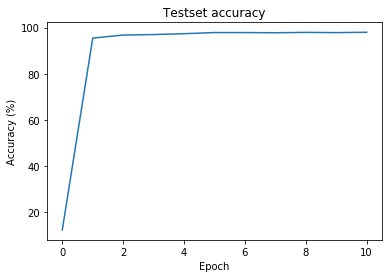

In [17]:
plt.plot(test_accuracies)
plt.title('Testset accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [19]:
dir_name = "out/models/LeNet_300_100_unbiased_22-10-2019_09:25:54"
epochs = list(range(21))
model_class = LeNet_300_100
s = Snapshots(dir_name, epochs, model_class, bias=False)

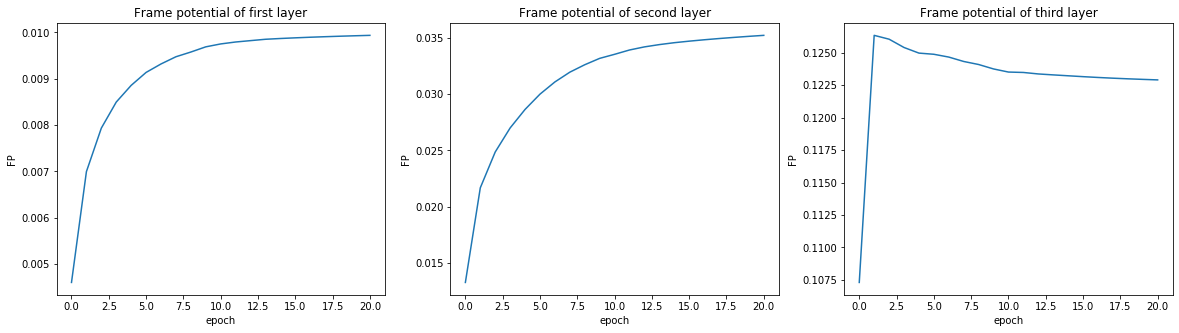

In [20]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, figsize=(20,5))
ax1.plot(s.compute_fps('fc1'))
ax1.set_title('Frame potential of first layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(s.compute_fps('fc2'))
ax2.set_title('Frame potential of second layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(s.compute_fps('fc3'))
ax3.set_title('Frame potential of third layer')
ax3.set(xlabel='epoch', ylabel='FP');

### Training model variants

#### LeNet-20-100

In [14]:
epochs = 20
optim_kwargs = {'lr': 0.003, 'momentum': 0.9}

In [15]:
model = LeNet_20_100(bias=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)

In [16]:
test_accuracies = e.fit(trainloader, testloader, epochs, save_results=True)


Test set: Average loss: 2.2975, Accuracy:   1236/ 10000 (12%)

Created model snapshot directory: out/models/LeNet_20_100_unbiased_22-10-2019_14:48:39
Train Epoch:   1 [     0/ 60000 (0%)]	Loss: 2.293132
Train Epoch:   1 [  1600/ 60000 (3%)]	Loss: 1.039487
Train Epoch:   1 [  3200/ 60000 (5%)]	Loss: 0.532614
Train Epoch:   1 [  4800/ 60000 (8%)]	Loss: 0.552131
Train Epoch:   1 [  6400/ 60000 (11%)]	Loss: 0.088112
Train Epoch:   1 [  8000/ 60000 (13%)]	Loss: 0.722190
Train Epoch:   1 [  9600/ 60000 (16%)]	Loss: 0.298492
Train Epoch:   1 [ 11200/ 60000 (19%)]	Loss: 0.825406
Train Epoch:   1 [ 12800/ 60000 (21%)]	Loss: 0.608552
Train Epoch:   1 [ 14400/ 60000 (24%)]	Loss: 0.414168
Train Epoch:   1 [ 16000/ 60000 (27%)]	Loss: 0.194952
Train Epoch:   1 [ 17600/ 60000 (29%)]	Loss: 0.313101
Train Epoch:   1 [ 19200/ 60000 (32%)]	Loss: 0.291741
Train Epoch:   1 [ 20800/ 60000 (35%)]	Loss: 0.119825
Train Epoch:   1 [ 22400/ 60000 (37%)]	Loss: 0.293109
Train Epoch:   1 [ 24000/ 60000 (40%)]	Loss

Train Epoch:   4 [ 51200/ 60000 (85%)]	Loss: 0.132092
Train Epoch:   4 [ 52800/ 60000 (88%)]	Loss: 0.644602
Train Epoch:   4 [ 54400/ 60000 (91%)]	Loss: 0.046808
Train Epoch:   4 [ 56000/ 60000 (93%)]	Loss: 0.343864
Train Epoch:   4 [ 57600/ 60000 (96%)]	Loss: 0.004863
Train Epoch:   4 [ 59200/ 60000 (99%)]	Loss: 0.148828

Test set: Average loss: 0.1392, Accuracy:   9590/ 10000 (96%)

Train Epoch:   5 [     0/ 60000 (0%)]	Loss: 0.001411
Train Epoch:   5 [  1600/ 60000 (3%)]	Loss: 0.485359
Train Epoch:   5 [  3200/ 60000 (5%)]	Loss: 0.059248
Train Epoch:   5 [  4800/ 60000 (8%)]	Loss: 0.028718
Train Epoch:   5 [  6400/ 60000 (11%)]	Loss: 0.008530
Train Epoch:   5 [  8000/ 60000 (13%)]	Loss: 0.028656
Train Epoch:   5 [  9600/ 60000 (16%)]	Loss: 0.012285
Train Epoch:   5 [ 11200/ 60000 (19%)]	Loss: 0.296086
Train Epoch:   5 [ 12800/ 60000 (21%)]	Loss: 0.133152
Train Epoch:   5 [ 14400/ 60000 (24%)]	Loss: 0.085337
Train Epoch:   5 [ 16000/ 60000 (27%)]	Loss: 0.037890
Train Epoch:   5 [ 176

Train Epoch:   8 [ 44800/ 60000 (75%)]	Loss: 0.000758
Train Epoch:   8 [ 46400/ 60000 (77%)]	Loss: 0.069027
Train Epoch:   8 [ 48000/ 60000 (80%)]	Loss: 0.167709
Train Epoch:   8 [ 49600/ 60000 (83%)]	Loss: 0.145836
Train Epoch:   8 [ 51200/ 60000 (85%)]	Loss: 0.018619
Train Epoch:   8 [ 52800/ 60000 (88%)]	Loss: 0.477825
Train Epoch:   8 [ 54400/ 60000 (91%)]	Loss: 0.030261
Train Epoch:   8 [ 56000/ 60000 (93%)]	Loss: 0.125920
Train Epoch:   8 [ 57600/ 60000 (96%)]	Loss: 0.031382
Train Epoch:   8 [ 59200/ 60000 (99%)]	Loss: 0.098624

Test set: Average loss: 0.1446, Accuracy:   9612/ 10000 (96%)

Train Epoch:   9 [     0/ 60000 (0%)]	Loss: 0.001639
Train Epoch:   9 [  1600/ 60000 (3%)]	Loss: 0.496984
Train Epoch:   9 [  3200/ 60000 (5%)]	Loss: 0.020199
Train Epoch:   9 [  4800/ 60000 (8%)]	Loss: 0.025800
Train Epoch:   9 [  6400/ 60000 (11%)]	Loss: 0.002153
Train Epoch:   9 [  8000/ 60000 (13%)]	Loss: 0.028647
Train Epoch:   9 [  9600/ 60000 (16%)]	Loss: 0.003869
Train Epoch:   9 [ 112

Train Epoch:  12 [ 38400/ 60000 (64%)]	Loss: 0.102747
Train Epoch:  12 [ 40000/ 60000 (67%)]	Loss: 0.005623
Train Epoch:  12 [ 41600/ 60000 (69%)]	Loss: 0.004425
Train Epoch:  12 [ 43200/ 60000 (72%)]	Loss: 0.072496
Train Epoch:  12 [ 44800/ 60000 (75%)]	Loss: 0.001179
Train Epoch:  12 [ 46400/ 60000 (77%)]	Loss: 0.065194
Train Epoch:  12 [ 48000/ 60000 (80%)]	Loss: 0.040017
Train Epoch:  12 [ 49600/ 60000 (83%)]	Loss: 0.147978
Train Epoch:  12 [ 51200/ 60000 (85%)]	Loss: 0.025403
Train Epoch:  12 [ 52800/ 60000 (88%)]	Loss: 0.447809
Train Epoch:  12 [ 54400/ 60000 (91%)]	Loss: 0.012441
Train Epoch:  12 [ 56000/ 60000 (93%)]	Loss: 0.032880
Train Epoch:  12 [ 57600/ 60000 (96%)]	Loss: 0.048755
Train Epoch:  12 [ 59200/ 60000 (99%)]	Loss: 0.165071

Test set: Average loss: 0.1602, Accuracy:   9612/ 10000 (96%)

Train Epoch:  13 [     0/ 60000 (0%)]	Loss: 0.003102
Train Epoch:  13 [  1600/ 60000 (3%)]	Loss: 0.525081
Train Epoch:  13 [  3200/ 60000 (5%)]	Loss: 0.053592
Train Epoch:  13 [  4

Train Epoch:  16 [ 32000/ 60000 (53%)]	Loss: 0.057171
Train Epoch:  16 [ 33600/ 60000 (56%)]	Loss: 0.013657
Train Epoch:  16 [ 35200/ 60000 (59%)]	Loss: 0.138089
Train Epoch:  16 [ 36800/ 60000 (61%)]	Loss: 0.003895
Train Epoch:  16 [ 38400/ 60000 (64%)]	Loss: 0.001772
Train Epoch:  16 [ 40000/ 60000 (67%)]	Loss: 0.002785
Train Epoch:  16 [ 41600/ 60000 (69%)]	Loss: 0.008513
Train Epoch:  16 [ 43200/ 60000 (72%)]	Loss: 0.191443
Train Epoch:  16 [ 44800/ 60000 (75%)]	Loss: 0.000243
Train Epoch:  16 [ 46400/ 60000 (77%)]	Loss: 0.061311
Train Epoch:  16 [ 48000/ 60000 (80%)]	Loss: 0.086093
Train Epoch:  16 [ 49600/ 60000 (83%)]	Loss: 0.053987
Train Epoch:  16 [ 51200/ 60000 (85%)]	Loss: 0.007008
Train Epoch:  16 [ 52800/ 60000 (88%)]	Loss: 0.229771
Train Epoch:  16 [ 54400/ 60000 (91%)]	Loss: 0.010706
Train Epoch:  16 [ 56000/ 60000 (93%)]	Loss: 0.115759
Train Epoch:  16 [ 57600/ 60000 (96%)]	Loss: 0.047319
Train Epoch:  16 [ 59200/ 60000 (99%)]	Loss: 0.076845

Test set: Average loss: 0.1

Train Epoch:  20 [ 25600/ 60000 (43%)]	Loss: 0.073359
Train Epoch:  20 [ 27200/ 60000 (45%)]	Loss: 0.008960
Train Epoch:  20 [ 28800/ 60000 (48%)]	Loss: 0.020580
Train Epoch:  20 [ 30400/ 60000 (51%)]	Loss: 0.000501
Train Epoch:  20 [ 32000/ 60000 (53%)]	Loss: 0.003369
Train Epoch:  20 [ 33600/ 60000 (56%)]	Loss: 0.018503
Train Epoch:  20 [ 35200/ 60000 (59%)]	Loss: 0.009806
Train Epoch:  20 [ 36800/ 60000 (61%)]	Loss: 0.001125
Train Epoch:  20 [ 38400/ 60000 (64%)]	Loss: 0.026400
Train Epoch:  20 [ 40000/ 60000 (67%)]	Loss: 0.000828
Train Epoch:  20 [ 41600/ 60000 (69%)]	Loss: 0.001429
Train Epoch:  20 [ 43200/ 60000 (72%)]	Loss: 0.329896
Train Epoch:  20 [ 44800/ 60000 (75%)]	Loss: 0.000065
Train Epoch:  20 [ 46400/ 60000 (77%)]	Loss: 0.004282
Train Epoch:  20 [ 48000/ 60000 (80%)]	Loss: 0.010377
Train Epoch:  20 [ 49600/ 60000 (83%)]	Loss: 0.029073
Train Epoch:  20 [ 51200/ 60000 (85%)]	Loss: 0.002293
Train Epoch:  20 [ 52800/ 60000 (88%)]	Loss: 0.408481
Train Epoch:  20 [ 54400/ 60

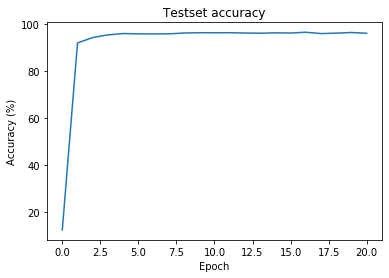

In [18]:
plt.plot(test_accuracies)
plt.title('Testset accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [22]:
dir_name = "out/models/LeNet_20_100_unbiased_22-10-2019_14:48:39"
epochs = list(range(21))
model_class = LeNet_20_100
s = Snapshots(dir_name, epochs, model_class, bias=False)

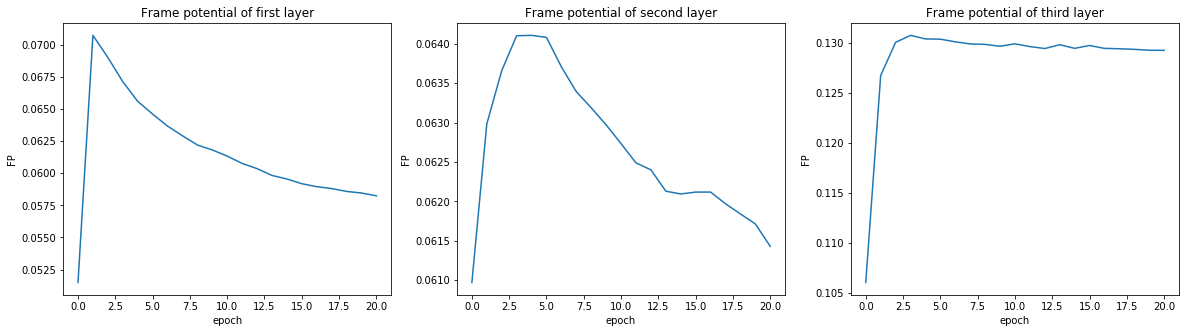

In [23]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, figsize=(20,5))
ax1.plot(s.compute_fps('fc1'))
ax1.set_title('Frame potential of first layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(s.compute_fps('fc2'))
ax2.set_title('Frame potential of second layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(s.compute_fps('fc3'))
ax3.set_title('Frame potential of third layer')
ax3.set(xlabel='epoch', ylabel='FP');

#### LeNet-300-10

In [24]:
epochs = 20
optim_kwargs = {'lr': 0.003, 'momentum': 0.9}

In [25]:
model = LeNet_300_10(bias=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)

In [26]:
test_accuracies = e.fit(trainloader, testloader, epochs, save_results=True)


Test set: Average loss: 2.3056, Accuracy:   1038/ 10000 (10%)

Created model snapshot directory: out/models/LeNet_300_10_unbiased_22-10-2019_14:57:41
Train Epoch:   1 [     0/ 60000 (0%)]	Loss: 2.309000
Train Epoch:   1 [  1600/ 60000 (3%)]	Loss: 1.093320
Train Epoch:   1 [  3200/ 60000 (5%)]	Loss: 0.518587
Train Epoch:   1 [  4800/ 60000 (8%)]	Loss: 0.525982
Train Epoch:   1 [  6400/ 60000 (11%)]	Loss: 0.079921
Train Epoch:   1 [  8000/ 60000 (13%)]	Loss: 0.704858
Train Epoch:   1 [  9600/ 60000 (16%)]	Loss: 0.385796
Train Epoch:   1 [ 11200/ 60000 (19%)]	Loss: 0.824883
Train Epoch:   1 [ 12800/ 60000 (21%)]	Loss: 0.525269
Train Epoch:   1 [ 14400/ 60000 (24%)]	Loss: 0.404396
Train Epoch:   1 [ 16000/ 60000 (27%)]	Loss: 0.192736
Train Epoch:   1 [ 17600/ 60000 (29%)]	Loss: 0.156741
Train Epoch:   1 [ 19200/ 60000 (32%)]	Loss: 0.067336
Train Epoch:   1 [ 20800/ 60000 (35%)]	Loss: 0.039491
Train Epoch:   1 [ 22400/ 60000 (37%)]	Loss: 0.272241
Train Epoch:   1 [ 24000/ 60000 (40%)]	Loss

Train Epoch:   4 [ 51200/ 60000 (85%)]	Loss: 0.045281
Train Epoch:   4 [ 52800/ 60000 (88%)]	Loss: 0.142887
Train Epoch:   4 [ 54400/ 60000 (91%)]	Loss: 0.007400
Train Epoch:   4 [ 56000/ 60000 (93%)]	Loss: 0.048146
Train Epoch:   4 [ 57600/ 60000 (96%)]	Loss: 0.002818
Train Epoch:   4 [ 59200/ 60000 (99%)]	Loss: 0.005171

Test set: Average loss: 0.0953, Accuracy:   9721/ 10000 (97%)

Train Epoch:   5 [     0/ 60000 (0%)]	Loss: 0.000948
Train Epoch:   5 [  1600/ 60000 (3%)]	Loss: 0.511712
Train Epoch:   5 [  3200/ 60000 (5%)]	Loss: 0.038343
Train Epoch:   5 [  4800/ 60000 (8%)]	Loss: 0.006000
Train Epoch:   5 [  6400/ 60000 (11%)]	Loss: 0.000938
Train Epoch:   5 [  8000/ 60000 (13%)]	Loss: 0.006329
Train Epoch:   5 [  9600/ 60000 (16%)]	Loss: 0.001819
Train Epoch:   5 [ 11200/ 60000 (19%)]	Loss: 0.108353
Train Epoch:   5 [ 12800/ 60000 (21%)]	Loss: 0.054961
Train Epoch:   5 [ 14400/ 60000 (24%)]	Loss: 0.006333
Train Epoch:   5 [ 16000/ 60000 (27%)]	Loss: 0.004673
Train Epoch:   5 [ 176

Train Epoch:   8 [ 44800/ 60000 (75%)]	Loss: 0.000898
Train Epoch:   8 [ 46400/ 60000 (77%)]	Loss: 0.002439
Train Epoch:   8 [ 48000/ 60000 (80%)]	Loss: 0.009656
Train Epoch:   8 [ 49600/ 60000 (83%)]	Loss: 0.003823
Train Epoch:   8 [ 51200/ 60000 (85%)]	Loss: 0.000457
Train Epoch:   8 [ 52800/ 60000 (88%)]	Loss: 0.021151
Train Epoch:   8 [ 54400/ 60000 (91%)]	Loss: 0.000119
Train Epoch:   8 [ 56000/ 60000 (93%)]	Loss: 0.017446
Train Epoch:   8 [ 57600/ 60000 (96%)]	Loss: 0.000208
Train Epoch:   8 [ 59200/ 60000 (99%)]	Loss: 0.000189

Test set: Average loss: 0.0972, Accuracy:   9769/ 10000 (98%)

Train Epoch:   9 [     0/ 60000 (0%)]	Loss: 0.002404
Train Epoch:   9 [  1600/ 60000 (3%)]	Loss: 0.343637
Train Epoch:   9 [  3200/ 60000 (5%)]	Loss: 0.002767
Train Epoch:   9 [  4800/ 60000 (8%)]	Loss: 0.031869
Train Epoch:   9 [  6400/ 60000 (11%)]	Loss: 0.001240
Train Epoch:   9 [  8000/ 60000 (13%)]	Loss: 0.011809
Train Epoch:   9 [  9600/ 60000 (16%)]	Loss: 0.000114
Train Epoch:   9 [ 112

Train Epoch:  12 [ 38400/ 60000 (64%)]	Loss: 0.008083
Train Epoch:  12 [ 40000/ 60000 (67%)]	Loss: 0.000134
Train Epoch:  12 [ 41600/ 60000 (69%)]	Loss: 0.003022
Train Epoch:  12 [ 43200/ 60000 (72%)]	Loss: 0.002764
Train Epoch:  12 [ 44800/ 60000 (75%)]	Loss: 0.000264
Train Epoch:  12 [ 46400/ 60000 (77%)]	Loss: 0.001060
Train Epoch:  12 [ 48000/ 60000 (80%)]	Loss: 0.006623
Train Epoch:  12 [ 49600/ 60000 (83%)]	Loss: 0.000270
Train Epoch:  12 [ 51200/ 60000 (85%)]	Loss: 0.000099
Train Epoch:  12 [ 52800/ 60000 (88%)]	Loss: 0.002080
Train Epoch:  12 [ 54400/ 60000 (91%)]	Loss: 0.000015
Train Epoch:  12 [ 56000/ 60000 (93%)]	Loss: 0.001332
Train Epoch:  12 [ 57600/ 60000 (96%)]	Loss: 0.000069
Train Epoch:  12 [ 59200/ 60000 (99%)]	Loss: 0.000021

Test set: Average loss: 0.0940, Accuracy:   9800/ 10000 (98%)

Train Epoch:  13 [     0/ 60000 (0%)]	Loss: 0.000098
Train Epoch:  13 [  1600/ 60000 (3%)]	Loss: 0.004823
Train Epoch:  13 [  3200/ 60000 (5%)]	Loss: 0.013034
Train Epoch:  13 [  4

Train Epoch:  16 [ 32000/ 60000 (53%)]	Loss: 0.001229
Train Epoch:  16 [ 33600/ 60000 (56%)]	Loss: 0.000419
Train Epoch:  16 [ 35200/ 60000 (59%)]	Loss: 0.001230
Train Epoch:  16 [ 36800/ 60000 (61%)]	Loss: 0.000012
Train Epoch:  16 [ 38400/ 60000 (64%)]	Loss: 0.004445
Train Epoch:  16 [ 40000/ 60000 (67%)]	Loss: 0.000259
Train Epoch:  16 [ 41600/ 60000 (69%)]	Loss: 0.000333
Train Epoch:  16 [ 43200/ 60000 (72%)]	Loss: 0.000398
Train Epoch:  16 [ 44800/ 60000 (75%)]	Loss: 0.000471
Train Epoch:  16 [ 46400/ 60000 (77%)]	Loss: 0.003297
Train Epoch:  16 [ 48000/ 60000 (80%)]	Loss: 0.000034
Train Epoch:  16 [ 49600/ 60000 (83%)]	Loss: 0.000940
Train Epoch:  16 [ 51200/ 60000 (85%)]	Loss: 0.000006
Train Epoch:  16 [ 52800/ 60000 (88%)]	Loss: 0.001779
Train Epoch:  16 [ 54400/ 60000 (91%)]	Loss: 0.000020
Train Epoch:  16 [ 56000/ 60000 (93%)]	Loss: 0.001149
Train Epoch:  16 [ 57600/ 60000 (96%)]	Loss: 0.000006
Train Epoch:  16 [ 59200/ 60000 (99%)]	Loss: 0.000005

Test set: Average loss: 0.0

Train Epoch:  20 [ 25600/ 60000 (43%)]	Loss: 0.000054
Train Epoch:  20 [ 27200/ 60000 (45%)]	Loss: 0.000039
Train Epoch:  20 [ 28800/ 60000 (48%)]	Loss: 0.000009
Train Epoch:  20 [ 30400/ 60000 (51%)]	Loss: 0.000006
Train Epoch:  20 [ 32000/ 60000 (53%)]	Loss: 0.000756
Train Epoch:  20 [ 33600/ 60000 (56%)]	Loss: 0.000243
Train Epoch:  20 [ 35200/ 60000 (59%)]	Loss: 0.000646
Train Epoch:  20 [ 36800/ 60000 (61%)]	Loss: 0.000010
Train Epoch:  20 [ 38400/ 60000 (64%)]	Loss: 0.003039
Train Epoch:  20 [ 40000/ 60000 (67%)]	Loss: 0.000166
Train Epoch:  20 [ 41600/ 60000 (69%)]	Loss: 0.000407
Train Epoch:  20 [ 43200/ 60000 (72%)]	Loss: 0.000249
Train Epoch:  20 [ 44800/ 60000 (75%)]	Loss: 0.000091
Train Epoch:  20 [ 46400/ 60000 (77%)]	Loss: 0.001315
Train Epoch:  20 [ 48000/ 60000 (80%)]	Loss: 0.000006
Train Epoch:  20 [ 49600/ 60000 (83%)]	Loss: 0.000890
Train Epoch:  20 [ 51200/ 60000 (85%)]	Loss: 0.000004
Train Epoch:  20 [ 52800/ 60000 (88%)]	Loss: 0.000485
Train Epoch:  20 [ 54400/ 60

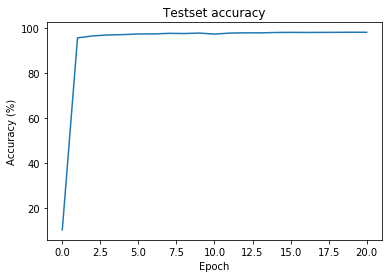

In [27]:
plt.plot(test_accuracies)
plt.title('Testset accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [28]:
dir_name = "out/models/LeNet_300_10_unbiased_22-10-2019_14:57:41"
epochs = list(range(21))
model_class = LeNet_300_10
s = Snapshots(dir_name, epochs, model_class, bias=False)

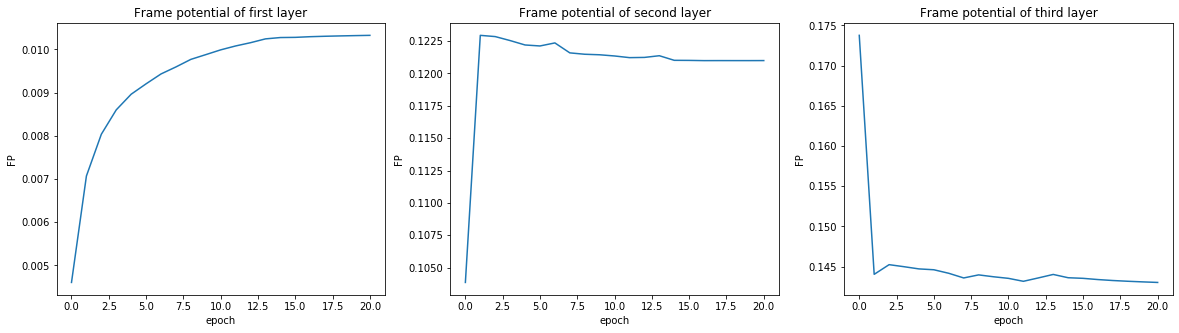

In [29]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, figsize=(20,5))
ax1.plot(s.compute_fps('fc1'))
ax1.set_title('Frame potential of first layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(s.compute_fps('fc2'))
ax2.set_title('Frame potential of second layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(s.compute_fps('fc3'))
ax3.set_title('Frame potential of third layer')
ax3.set(xlabel='epoch', ylabel='FP');

### Analysis of the weight matrices

#### First fully connected layer

In [12]:
dir_name = "out/models/LeNet_300_100_unbiased_22-10-2019_09:25:54"
epochs = list(range(21))
model_class = LeNet_300_100
layer = "fc1"

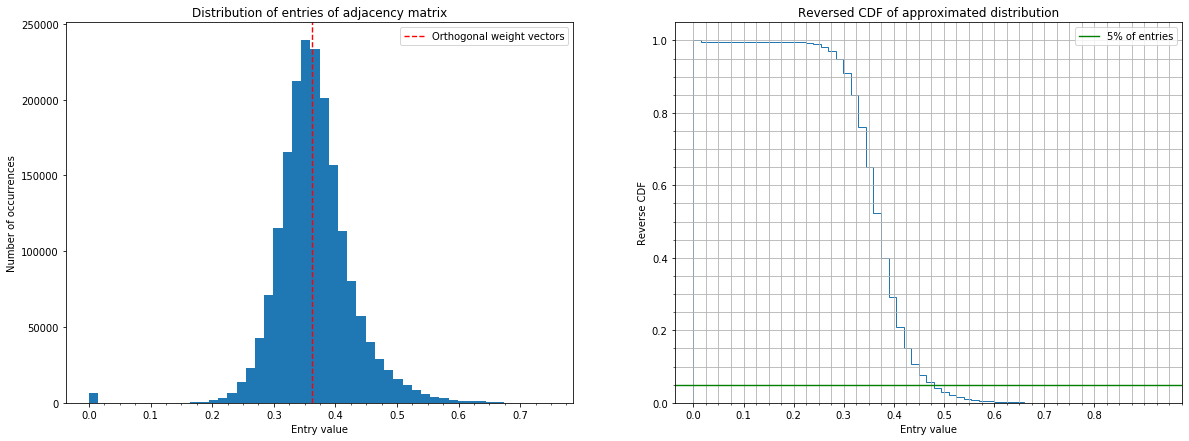

In [13]:
adjacency, weight_norms, _ = statistics.weight_dist(dir_name, epochs, model_class, layer, bias=False)

In [14]:
min_thresh = 0.45
step = 0.005
n_thresh = 55
max_thresh = min_thresh + (n_thresh-1)*step
thresholds = np.linspace(min_thresh, max_thresh, n_thresh)

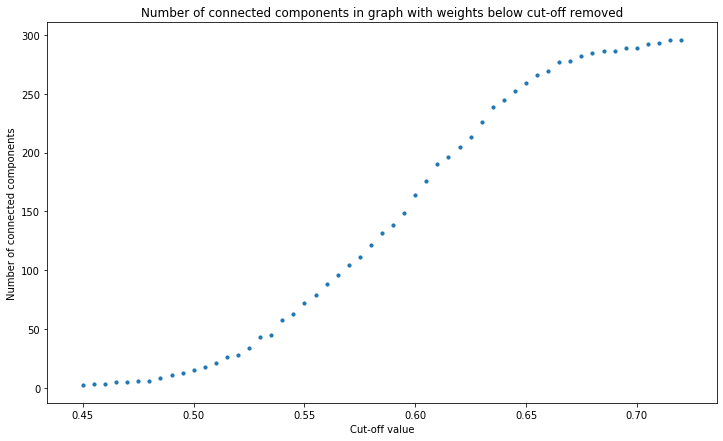

In [15]:
statistics.plot_connected_components(adjacency, thresholds)

In [16]:
plot_data = statistics.cc_max_norm(adjacency, weight_norms, thresholds)

In [17]:
int_slider = IntSlider(value=0, min=0, max=len(plot_data)-1)
interact(length_mag_plot, plot_data=fixed(plot_data), thresholds=fixed(thresholds), idx=int_slider);

interactive(children=(IntSlider(value=0, description='idx', max=54), Output()), _dom_classes=('widget-interact…

In [18]:
cut_off = 0.615

In [19]:
w = adjacency.copy()
w[w < cut_off] = 0.
graph = statistics.training_graph(w, weight_norms, graph_name="nn_graph.json")

#### Biases

In [ ]:
b = s.get_biases(layer).numpy()

In [252]:
b_mean = b.mean(axis=0)
std_dev = b.std(axis=0)

epochs = b.shape[0]
n_nodes = b.shape[1]

In [255]:
int_slider = IntSlider(value=0, min=0, max=epochs-1)

def plot_figure(plot_data, idx):
    fig = plt.figure(figsize=(12,7))
    plt.hist(plot_data[idx], bins=20)
    plt.title("Title")
    plt.xlabel("x")
    plt.ylabel("y")
    
interact(plot_figure, plot_data=fixed(b), idx=int_slider);

interactive(children=(IntSlider(value=0, description='idx', max=9), Output()), _dom_classes=('widget-interact'…

In [266]:
n_models = weights.shape[0]
last_model = weights[n_models-1]
w = last_model.copy()
w[w < thresh] = 0
G = nx.from_numpy_matrix(w)
cc_ls = list(nx.connected_components(G))

In [267]:
last_b = b[epochs-1]
print("Last model bias standard deviation:", last_b.std())
for connected_component in cc_ls:
    cc_size = len(connected_component)
    node_selection = list(connected_component)
    cc_biases = last_b[node_selection]
    if cc_size > 1:
        std_dev = cc_biases.std()
        print(f"Size: {cc_size}, std_dev: {std_dev}")

Last model bias standard deviation: 0.02163267
Size: 214, std_dev: 0.02180653065443039
Size: 2, std_dev: 0.0013638203963637352
Size: 2, std_dev: 0.0005322825163602829
Size: 2, std_dev: 0.014326034113764763
Size: 2, std_dev: 0.018552163615822792
Size: 2, std_dev: 0.005734095349907875


#### Second fully connected layer

In [20]:
dir_name = "out/models/LeNet_300_100_unbiased_22-10-2019_09:25:54"
epochs = list(range(21))
model_class = LeNet_300_100
layer = "fc2"

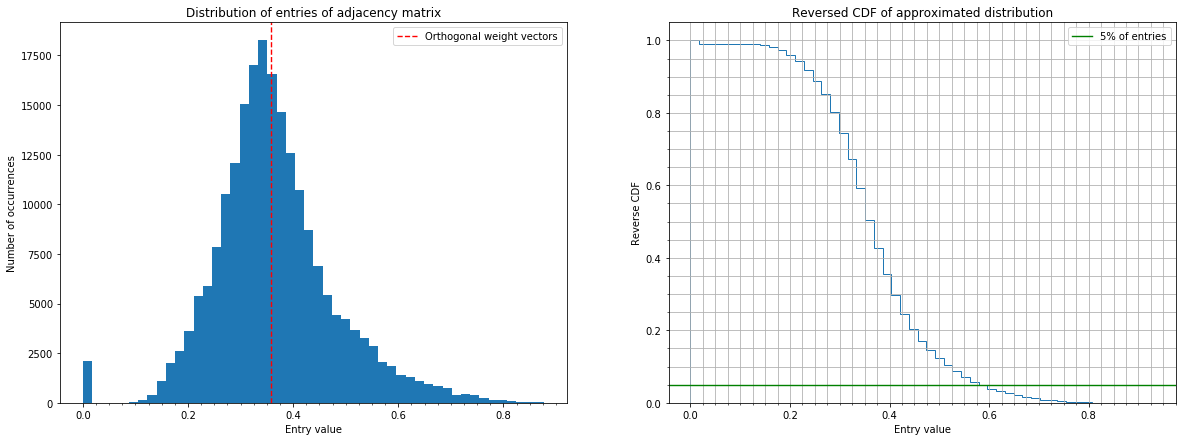

In [21]:
adjacency, weight_norms, _ = statistics.weight_dist(dir_name, epochs, model_class, layer, bias=False)

In [48]:
min_thresh = 0.5
step = 0.005
n_thresh = 55
max_thresh = min_thresh + (n_thresh-1)*step
thresholds = np.linspace(min_thresh, max_thresh, n_thresh)

In [ ]:
statistics.plot_connected_components(adjacency, thresholds)

In [24]:
plot_data = statistics.cc_max_norm(adjacency, weight_norms, thresholds)

In [25]:
int_slider = IntSlider(value=0, min=0, max=len(plot_data)-1)
interact(length_mag_plot, plot_data=fixed(plot_data), thresholds=fixed(thresholds), idx=int_slider);

interactive(children=(IntSlider(value=0, description='idx', max=54), Output()), _dom_classes=('widget-interact…

In [26]:
cut_off = 0.710

In [27]:
w = adjacency.copy()
w[w < cut_off] = 0.
graph = statistics.training_graph(w, weight_norms, graph_name="nn_graph.json")

### Comparing over-parametrized model to variants

In [163]:
dir_name = "out/models/LeNet_300_100_unbiased_22-10-2019_09:25:54"
epochs = list(range(21))
model_class = LeNet_300_100

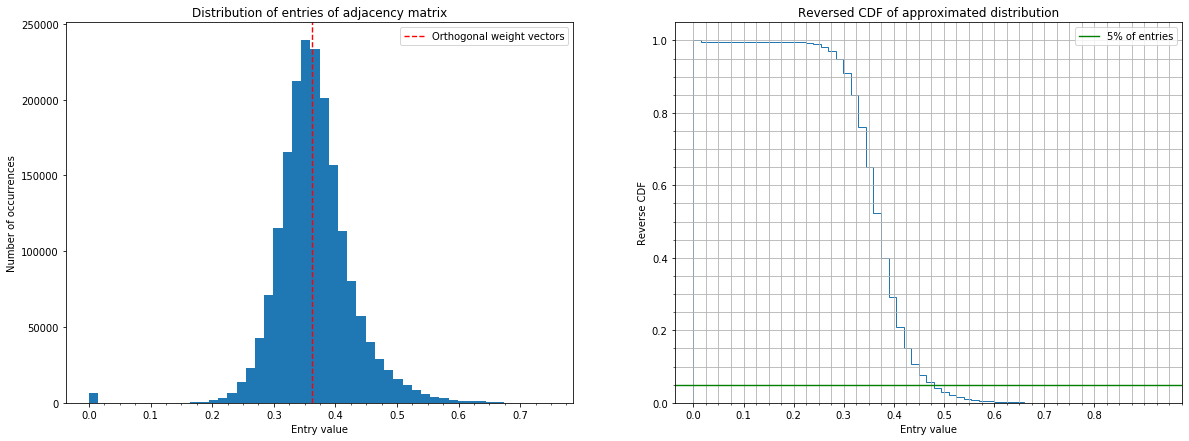

In [164]:
adjacency, weight_norms, kernel_width = statistics.weight_dist(dir_name, epochs, model_class, 'fc1', bias=False)

In [165]:
s = Snapshots(dir_name, epochs, model_class, bias=False)

In [166]:
getattr(s.models[20], 'fc1').get_weights().shape

torch.Size([300, 784])

In [167]:
dir_name_mod = "out/models/LeNet_20_100_unbiased_22-10-2019_14:48:39"
epochs = list(range(21))
model_class_mod = LeNet_20_100
s_mod = Snapshots(dir_name_mod, epochs, model_class_mod, bias=False)

In [168]:
other_weights = s_mod.get_weights('fc1')[20]
other_weights.shape

torch.Size([20, 784])

In [170]:
init_w = s.get_weights('fc1')[0]
init_w_mod = s_mod.get_weights('fc1')[0]

In [171]:
i = 0
print(init_w[i][:5])
print(init_w_mod[i][:5])

tensor([-0.0149,  0.0063,  0.0092, -0.0312,  0.0169])
tensor([-0.0149,  0.0063,  0.0092, -0.0312,  0.0169])


In [172]:
inner_products = s.compute_ips_with('fc1', other_weights, 20)

In [173]:
def transform(inner_products, kernel_width):
    ips_mod = -0.5 * (inner_products - 1)
    adjacency = np.exp(-ips_mod ** 2 / (kernel_width ** 2))
    return adjacency

In [176]:
adj_mod = transform(inner_products, kernel_width).numpy()

In [175]:
adj_mod.shape

(20, 300)

In [177]:
values, indices = adj_mod.max(dim=1)

In [179]:
diff = (indices - torch.arange(20)).numpy()

In [182]:
np.argwhere(diff == 0).flatten()

array([ 4, 11])

In [188]:
print(values[4].item(), values[11].item()) 

tensor(0.7079) tensor(0.7443)


In [185]:
indices = np.argsort(weight_norms_mod[20])
print(indices)

[18 11 14  7 17 12  8  4 13  6  9  0  2  3 16 10  5 19 15  1]


In [116]:
cut_off = adj_mod.max(axis=1).min()

In [117]:
cut_off

0.6103219

In [118]:
adj_mod[adj_mod < cut_off] = 0.

In [183]:
_, weight_norms_mod, _ = statistics.weight_dist(dir_name_mod, epochs, model_class_mod, 'fc1', bias=False)

In [110]:
weight_norms_mod.shape

(21, 20)

In [111]:
import json

with open("viz/nn_graph.json", 'r') as fp:
    graph = json.load(fp)

In [112]:
graph

{'nodes': [{'id': '0',
   'fraction': {'0': 0.576,
    '1': 0.673,
    '2': 0.711,
    '3': 0.74,
    '4': 0.769,
    '5': 0.792,
    '6': 0.814,
    '7': 0.834,
    '8': 0.85,
    '9': 0.863,
    '10': 0.873,
    '11': 0.879,
    '12': 0.882,
    '13': 0.885,
    '14': 0.887,
    '15': 0.888,
    '16': 0.89,
    '17': 0.891,
    '18': 0.892,
    '19': 0.893,
    '20': 0.894}},
  {'id': '1',
   'fraction': {'0': 0.591,
    '1': 0.65,
    '2': 0.679,
    '3': 0.703,
    '4': 0.725,
    '5': 0.746,
    '6': 0.759,
    '7': 0.768,
    '8': 0.776,
    '9': 0.783,
    '10': 0.784,
    '11': 0.791,
    '12': 0.794,
    '13': 0.796,
    '14': 0.797,
    '15': 0.798,
    '16': 0.799,
    '17': 0.8,
    '18': 0.801,
    '19': 0.801,
    '20': 0.802}},
  {'id': '2',
   'fraction': {'0': 0.58,
    '1': 0.605,
    '2': 0.636,
    '3': 0.659,
    '4': 0.679,
    '5': 0.696,
    '6': 0.712,
    '7': 0.727,
    '8': 0.737,
    '9': 0.747,
    '10': 0.755,
    '11': 0.759,
    '12': 0.761,
    '13': 0

In [119]:
start_idx = 300

n_epochs = adjacency.shape[0]
n_nodes = adjacency.shape[1]
new_nodes = adj_mod.shape[0]

for node_id in range(new_nodes):
    node_id_mod = node_id + start_idx
    norms = {str(epoch): float("{:.3f}".format(weight_norms_mod[epoch, node_id])) for epoch in range(n_epochs)}
    node_entry = {"id": str(node_id_mod), "fraction": norms}
    graph["nodes"].append(node_entry)

for i in range(new_nodes):
    for j in range(n_nodes):
        edge_weight = adj_mod[i, j]
        if edge_weight:
            i_mod = i + start_idx
            edge_entry = {"source": str(i_mod), "target": str(j), "value": float("{:.3f}".format(edge_weight)),
                          "year": n_epochs-1}
            graph["links"].append(edge_entry)


graph_fname = os.path.join(common.VIZ_DIR, "nn_graph.json")
with open(graph_fname, 'w') as fp:
    json.dump(graph, fp, indent=4)

#### Second fully connected layer

In [63]:
dir_name = "out/models/LeNet_300_100_unbiased_22-10-2019_09:25:54"
epochs = list(range(21))
model_class = LeNet_300_100

In [64]:
s = Snapshots(dir_name, epochs, model_class, bias=False)

In [65]:
getattr(s.models[20], 'fc2').get_weights().shape

torch.Size([100, 300])

In [66]:
dir_name_mod = "out/models/LeNet_300_10_unbiased_22-10-2019_14:57:41"
epochs = list(range(21))
model_class_mod = LeNet_300_10
s_mod = Snapshots(dir_name_mod, epochs, model_class_mod, bias=False)

In [73]:
other_weights = s_mod.get_weights('fc2')[20]
other_weights.shape

torch.Size([10, 300])

In [74]:
inner_products = s.compute_ips_with('fc2', other_weights, 20)

In [75]:
inner_products.shape

torch.Size([10, 100])

In [76]:
for i in range(inner_products.shape[0]):
    row = inner_products[i]
    indices = (row.abs() > 0.1)
    print(i, row.abs()[indices])

0 tensor([0.1265, 0.1030, 0.1022, 0.1620])
1 tensor([0.1101, 0.1215, 0.1165, 0.1100, 0.1001, 0.1374, 0.1073, 0.1075, 0.1013,
        0.1111])
2 tensor([0.1024, 0.1340, 0.1370, 0.1652, 0.1484, 0.1235, 0.1408, 0.1074, 0.1094,
        0.1004])
3 tensor([0.1189, 0.1031, 0.1060, 0.1354, 0.1216, 0.1234])
4 tensor([0.1096, 0.1223, 0.1747, 0.1011, 0.1713, 0.1012, 0.1112, 0.1053, 0.1137,
        0.1051])
5 tensor([0.1146, 0.1044, 0.1509, 0.1074, 0.1065, 0.1336, 0.1280, 0.1233, 0.1019,
        0.1204, 0.1104, 0.1239, 0.1087, 0.1145, 0.1138, 0.1252])
6 tensor([0.1511, 0.1151, 0.1064, 0.1144])
7 tensor([0.1006, 0.1426, 0.1329, 0.1606])
8 tensor([0.1202, 0.1035, 0.1079, 0.1148, 0.1620])
9 tensor([0.1205, 0.1108, 0.1221, 0.1361, 0.1195, 0.1000, 0.1056, 0.1830, 0.1071,
        0.1396, 0.1460, 0.1143])


### Pruning LeNet-300-100

In [17]:
layers = ['fc1']
exp_acc, exp_fps, pruning_accuracies, pruning_fps = mnist_pruning(testloader, layers, pruning_ratio=0.9, include_random=False, n_rounds=5, save_results=True)

Pruning using: max_fp_pruning

Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0746, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9823/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9823/ 10000 (98%)


Test set: Average loss: 0.0748, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0748, Accuracy:   9822/ 10000 (98%)


Test set: Average loss: 0.0749, Accuracy:   9823/ 10000 (98%)

Pruning round: [ 10/270 (4%)]

Test set: Average loss: 0.0748, Accuracy:   9819/ 10000 (98%)


Test set: Average loss: 0.0746, Accuracy:   9819/ 10000 (98%)


Test set: Average loss: 0.0745, Accuracy:   9819/ 10000 (98%)


Test set: Average loss: 0.0744, Accuracy:  

In [0]:
fname_exp_acc = "out/metrics/pruning/LeNet_300_100_fc1_random_pruning_0.9_acc_14-10-2019_12:59:03.npy"
fname_exp_fps = "out/metrics/pruning/LeNet_300_100_fc1_random_pruning_0.9_fp_14-10-2019_12:59:03.npy"
fname_pruning_acc = "out/metrics/pruning/LeNet_300_100_fc1_combined_0.9_acc_15-10-2019_07:55:34.npy"  
fname_pruning_fps = "out/metrics/pruning/LeNet_300_100_fc1_combined_0.9_fp_15-10-2019_07:55:34.npy"  

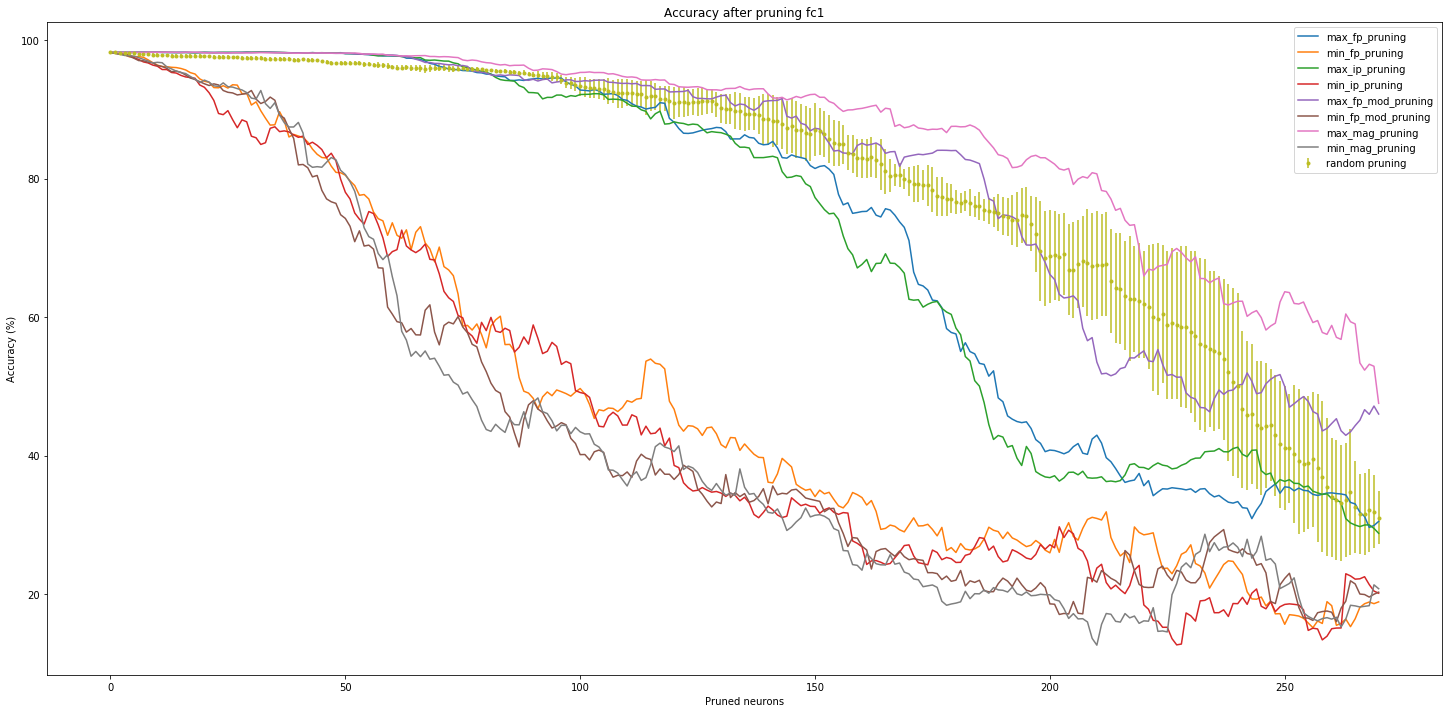

In [21]:
helpers.draw_acc_plot('fc1', fname_exp_acc, fname_pruning_acc, fig_name="LeNet_300_100_fc1_combined_0.9_acc_15-10-2019_07:55:34")

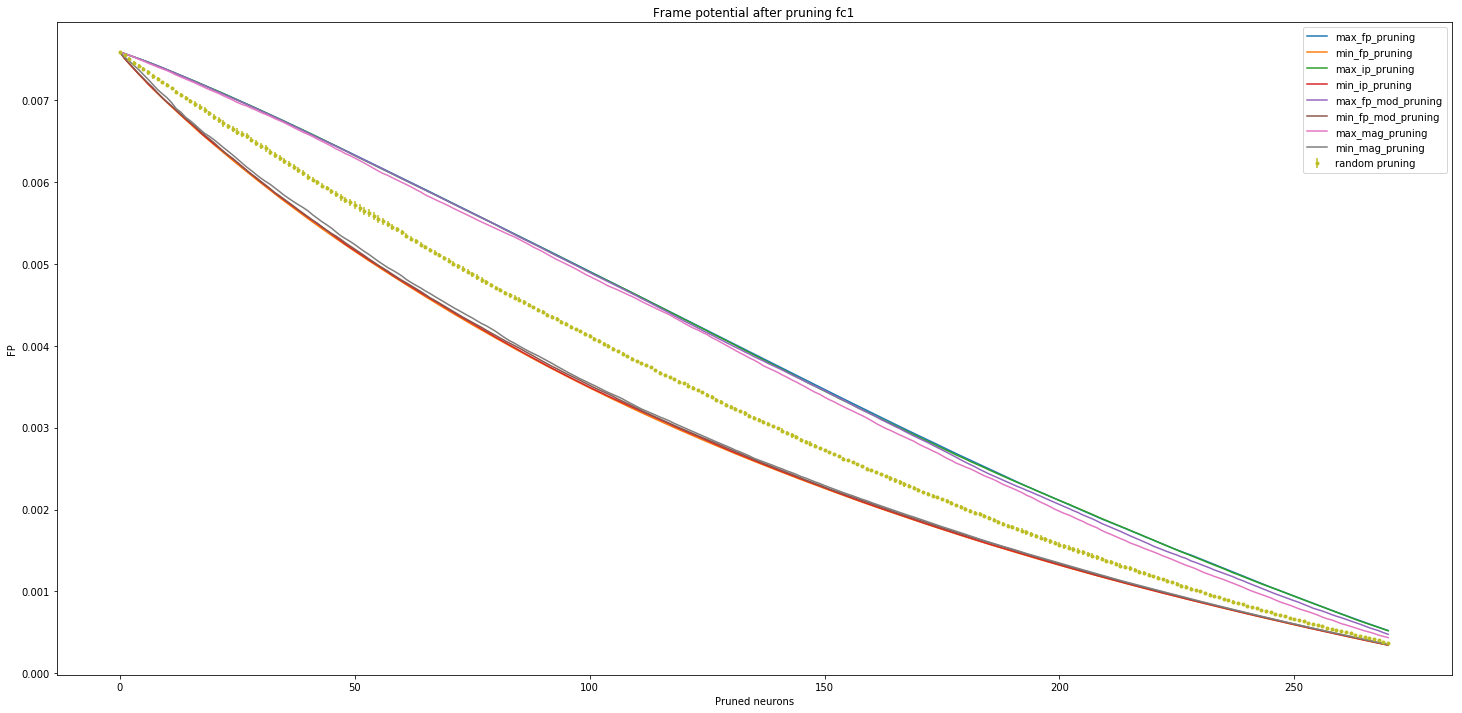

In [22]:
helpers.draw_fps_plot('fc1', fname_exp_fps, fname_pruning_fps, fig_name="LeNet_300_100_fc1_combined_0.9_fp_15-10-2019_07:55:34")

In [23]:
layers = ['fc2']
exp_acc, exp_fps, pruning_accuracies, pruning_fps = mnist_pruning(testloader, layers, pruning_ratio=0.9, include_random=True, n_rounds=5, save_results=True)

Random pruning experiment:

Random pruning experiment N° 1

Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0792, Accuracy:   9812/ 10000 (98%)


Test set: Average loss: 0.0839, Accuracy:   9805/ 10000 (98%)


Test set: Average loss: 0.0839, Accuracy:   9805/ 10000 (98%)


Test set: Average loss: 0.0805, Accuracy:   9806/ 10000 (98%)


Test set: Average loss: 0.0783, Accuracy:   9811/ 10000 (98%)


Test set: Average loss: 0.0806, Accuracy:   9805/ 10000 (98%)


Test set: Average loss: 0.0840, Accuracy:   9795/ 10000 (98%)


Test set: Average loss: 0.0838, Accuracy:   9792/ 10000 (98%)


Test set: Average loss: 0.0835, Accuracy:   9793/ 10000 (98%)


Test set: Average loss: 0.0804, Accuracy:   9793/ 10000 (98%)

Pruning round: [ 10/ 90 (11%)]

Test set: Average loss: 0.0805, Accuracy:   9796/ 10000 (98%)


Test set: Average loss: 0.0808, Accuracy:   9794/ 10000 (98%)


Test set: Average loss: 0.0947, Accuracy:   9766/ 10000 (98%)


Test set: Ave

In [0]:
fname_exp_acc = "out/metrics/pruning/LeNet_300_100_fc2_random_pruning_0.9_acc_15-10-2019_08:12:16.npy"
fname_exp_fps = "out/metrics/pruning/LeNet_300_100_fc2_random_pruning_0.9_fp_15-10-2019_08:12:16.npy"
fname_pruning_acc = "out/metrics/pruning/LeNet_300_100_fc2_combined_0.9_acc_15-10-2019_08:33:28.npy"
fname_pruning_fps = "out/metrics/pruning/LeNet_300_100_fc2_combined_0.9_fp_15-10-2019_08:33:28.npy"

In [33]:
helpers.draw_acc_plot('fc2', fname_exp_acc, fname_pruning_acc, fig_name="LeNet_300_100_fc2_combined_0.9_acc_15-10-2019_08:33:28")

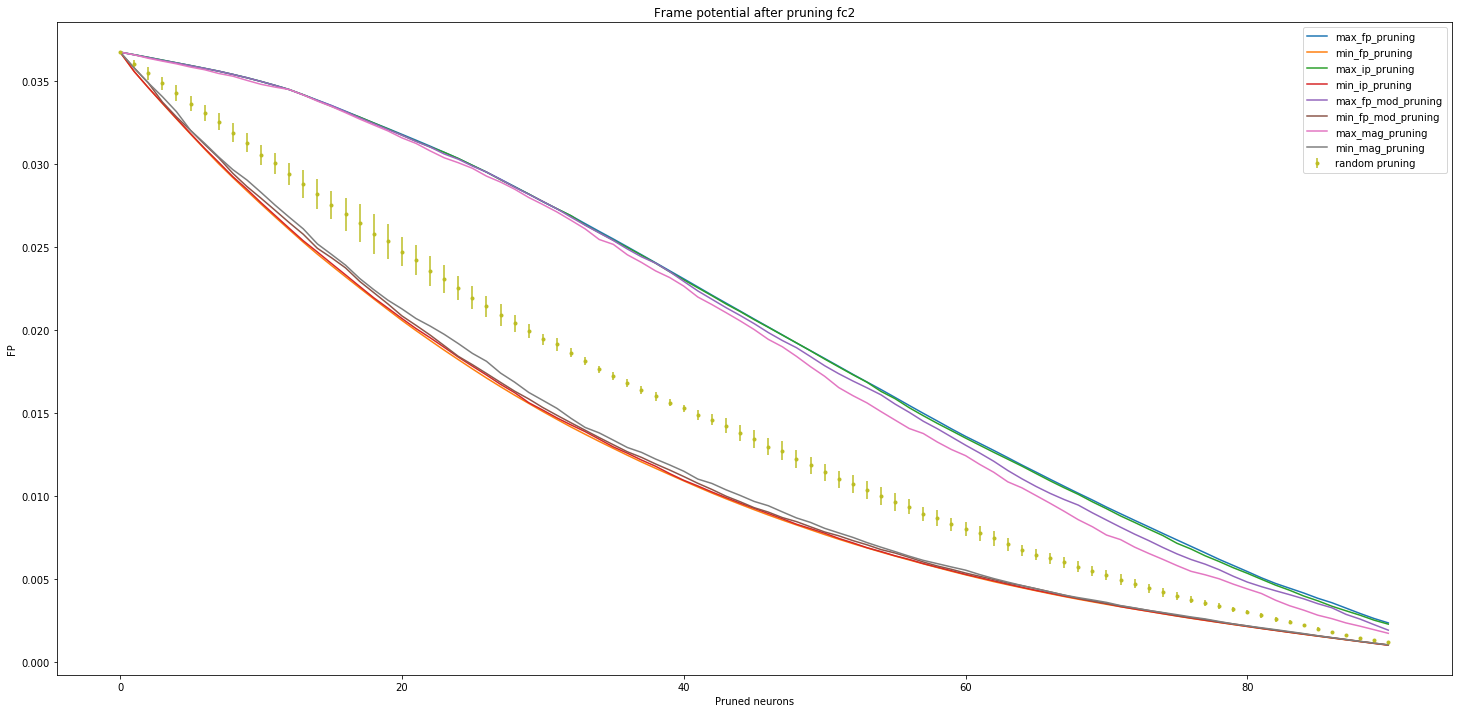

In [34]:
helpers.draw_fps_plot('fc2', fname_exp_fps, fname_pruning_fps, fig_name="LeNet_300_100_fc2_combined_0.9_fp_15-10-2019_08:33:28")

#### Pruning schedules

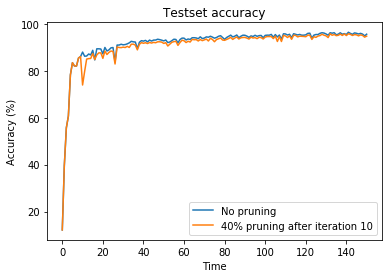

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[10], label="40% pruning after iteration 10")
plt.title('Testset accuracy')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

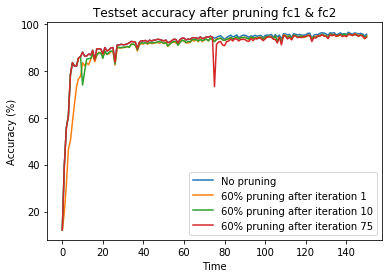

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="60% pruning after iteration 1")
plt.plot(accuracies[10], label="60% pruning after iteration 10")
plt.plot(accuracies[75], label="60% pruning after iteration 75")
plt.title('Testset accuracy after pruning fc1 & fc2')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

### Show images, compare class results

In [0]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [0]:
print(images.shape)
print(labels.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n', ' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: \n', ' '.join('%9s' % classes[predicted[j]]
                              for j in range(4)))

Predicted: 
         7         2         1         0


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 98 %
Accuracy of 1 : 97 %
Accuracy of 2 : 89 %
Accuracy of 3 : 96 %
Accuracy of 4 : 100 %
Accuracy of 5 : 92 %
Accuracy of 6 : 94 %
Accuracy of 7 : 96 %
Accuracy of 8 : 98 %
Accuracy of 9 : 97 %


## CIFAR-10 / Conv-2

### Loading the data

In [12]:
train_batch_size = 64
test_batch_size = 1000

In [13]:
trainloader, testloader, classes = get_cifar(train_batch_size, test_batch_size)

Files already downloaded and verified
Files already downloaded and verified


### Training the model

In [83]:
epochs = 10
optim_kwargs = {'lr': 0.0002}

In [84]:
model = Conv2(bias=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)

In [85]:
test_accuracies = e.fit(trainloader, testloader, epochs, save_results=True)


Test set: Average loss: 2.3043, Accuracy:   1044/ 10000 (10%)

Created model snapshot directory: out/models/Conv2_22-10-2019_10:54:39
Train Epoch:   1 [     0/ 50000 (0%)]	Loss: 2.309559
Train Epoch:   1 [  6400/ 50000 (13%)]	Loss: 1.720264
Train Epoch:   1 [ 12800/ 50000 (26%)]	Loss: 1.372375
Train Epoch:   1 [ 19200/ 50000 (38%)]	Loss: 1.504041
Train Epoch:   1 [ 25600/ 50000 (51%)]	Loss: 1.223895
Train Epoch:   1 [ 32000/ 50000 (64%)]	Loss: 1.449000
Train Epoch:   1 [ 38400/ 50000 (77%)]	Loss: 1.311750
Train Epoch:   1 [ 44800/ 50000 (90%)]	Loss: 1.335843

Test set: Average loss: 1.1740, Accuracy:   5906/ 10000 (59%)

Saved final model to: out/models/Conv2_22-10-2019_10:54:39/1


In [16]:
dir_name = "out/models/Conv2_unbiased_22-10-2019_09:06:02"
epochs = list(range(11))
model_class = Conv2
s = Snapshots(dir_name, epochs, model_class, bias=False)

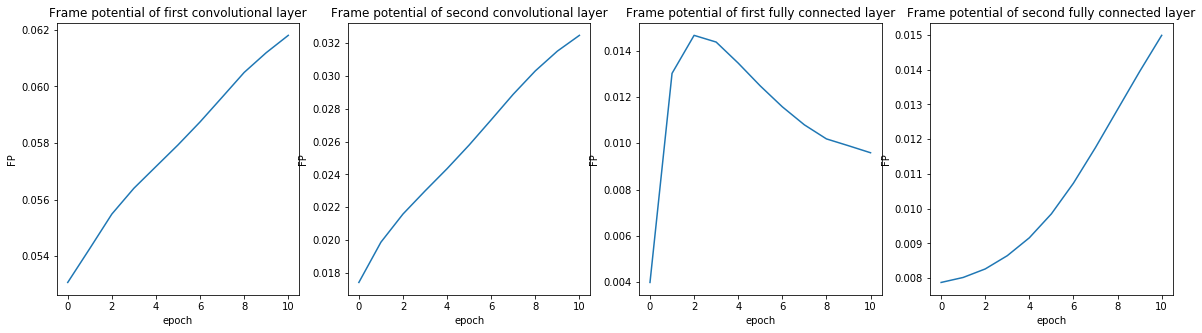

In [17]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex=True, figsize=(20,5))
ax1.plot(s.compute_fps('conv1'))
ax1.set_title('Frame potential of first convolutional layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(s.compute_fps('conv2'))
ax2.set_title('Frame potential of second convolutional layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(s.compute_fps('fc1'))
ax3.set_title('Frame potential of first fully connected layer')
ax3.set(xlabel='epoch', ylabel='FP')
ax4.plot(s.compute_fps('fc2'))
ax4.set_title('Frame potential of second fully connected layer')
ax4.set(xlabel='epoch', ylabel='FP');

### Training a model variant

In [14]:
epochs = 10
optim_kwargs = {'lr': 0.0002}

In [15]:
model = Conv2_30()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)

In [ ]:
test_accuracies = e.fit(trainloader, testloader, epochs, save_results=True)

In [14]:
dir_name = "out/models/Conv2_30_unbiased_22-10-2019_15:06:42"
epochs = list(range(11))
model_class = Conv2_30
s = Snapshots(dir_name, epochs, model_class, bias=False)

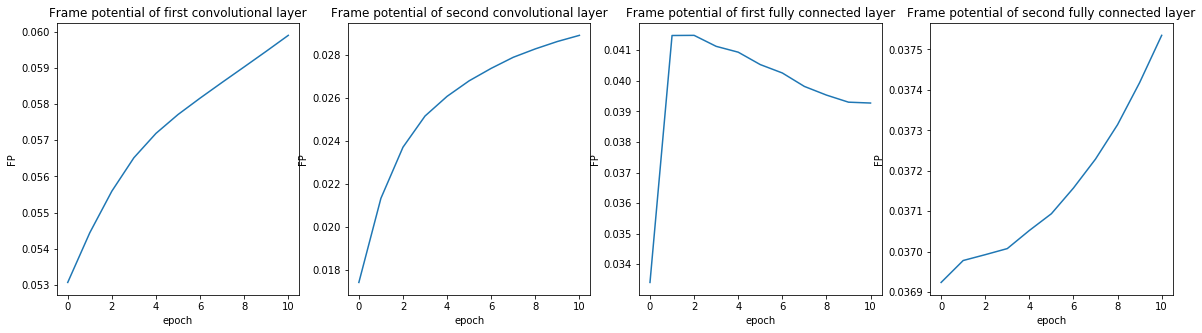

In [15]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex=True, figsize=(20,5))
ax1.plot(s.compute_fps('conv1'))
ax1.set_title('Frame potential of first convolutional layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(s.compute_fps('conv2'))
ax2.set_title('Frame potential of second convolutional layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(s.compute_fps('fc1'))
ax3.set_title('Frame potential of first fully connected layer')
ax3.set(xlabel='epoch', ylabel='FP')
ax4.plot(s.compute_fps('fc2'))
ax4.set_title('Frame potential of second fully connected layer')
ax4.set(xlabel='epoch', ylabel='FP');

### Analyses of the weight matrices

#### First fully connected layer

In [54]:
dir_name = "out/models/Conv2_unbiased_22-10-2019_09:06:02"
epochs = list(range(11))
model_class = Conv2
layer = "fc1"

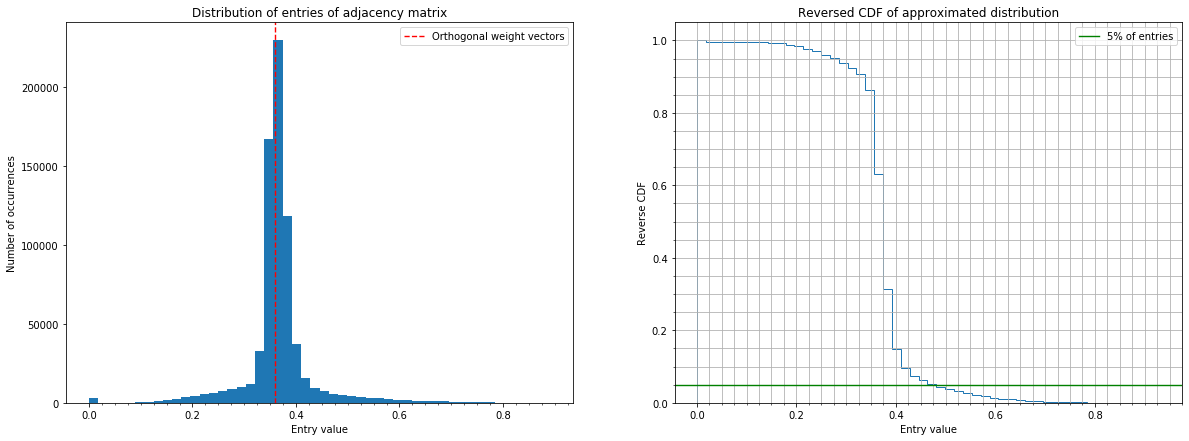

In [55]:
adjacency, weight_norms, _ = statistics.weight_dist(dir_name, epochs, model_class, layer, bias=False)

In [56]:
min_thresh = 0.40
step = 0.005
n_thresh = 55
max_thresh = min_thresh + (n_thresh-1)*step
thresholds = np.linspace(min_thresh, max_thresh, n_thresh)

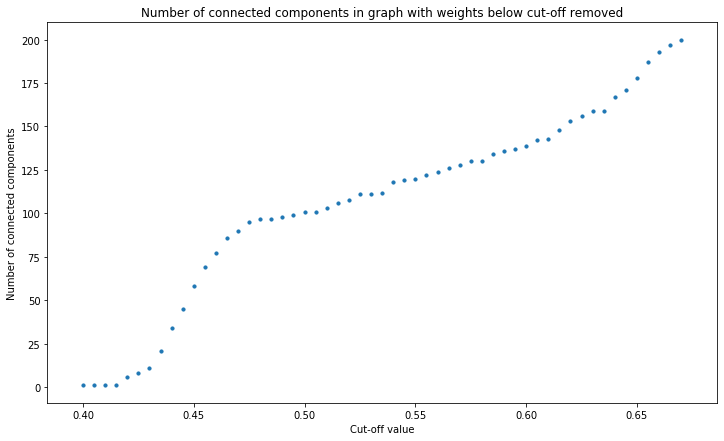

In [57]:
statistics.plot_connected_components(adjacency, thresholds)

In [58]:
plot_data = statistics.cc_max_norm(adjacency, weight_norms, thresholds)

In [59]:
int_slider = IntSlider(value=0, min=0, max=len(plot_data)-1)
interact(length_mag_plot, plot_data=fixed(plot_data), thresholds=fixed(thresholds), idx=int_slider);

interactive(children=(IntSlider(value=0, description='idx', max=54), Output()), _dom_classes=('widget-interact…

In [26]:
cut_off = 0.5

In [60]:
w = adjacency.copy()
w[w < cut_off] = 0.
graph = statistics.training_graph(w, weight_norms, graph_name="nn_graph.json")

#### Second fully connected layer

In [63]:
dir_name = "out/models/Conv2_unbiased_22-10-2019_09:06:02"
epochs = list(range(11))
model_class = Conv2
layer = "fc2"

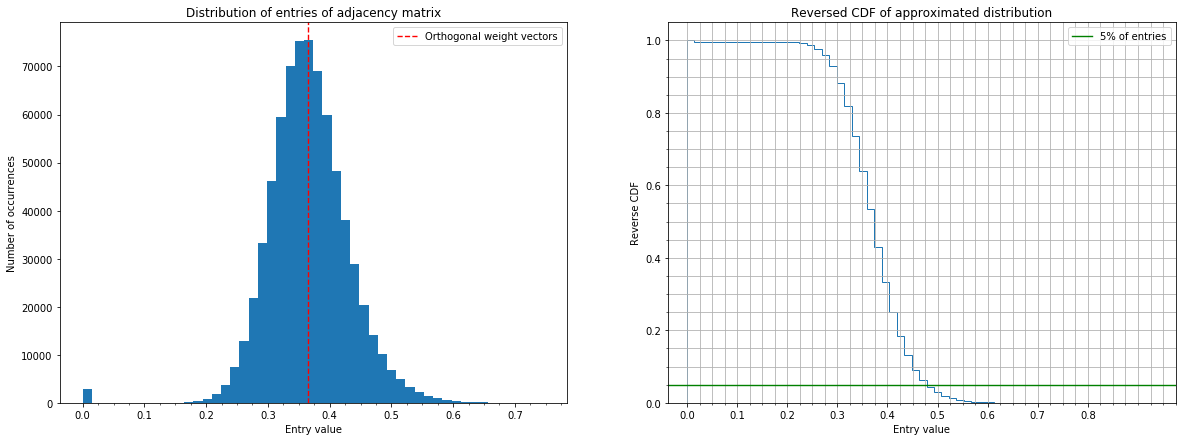

In [64]:
adjacency, weight_norms, _ = statistics.weight_dist(dir_name, epochs, model_class, layer, bias=False)

In [67]:
min_thresh = 0.45
step = 0.005
n_thresh = 55
max_thresh = min_thresh + (n_thresh-1)*step
thresholds = np.linspace(min_thresh, max_thresh, n_thresh)

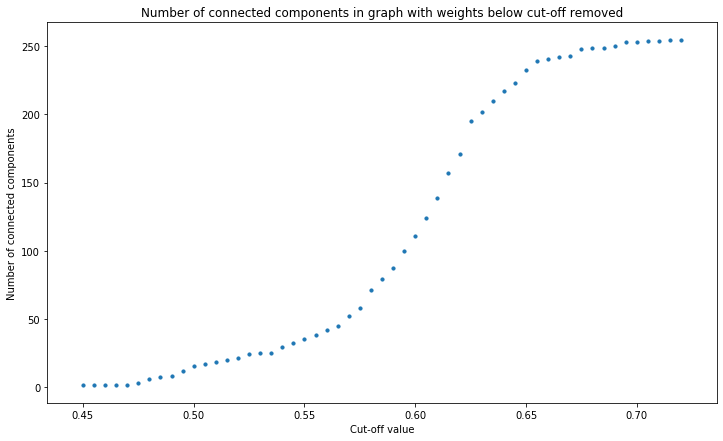

In [68]:
statistics.plot_connected_components(adjacency, thresholds)

In [69]:
plot_data = statistics.cc_max_norm(adjacency, weight_norms, thresholds)

In [70]:
int_slider = IntSlider(value=0, min=0, max=len(plot_data)-1)
interact(length_mag_plot, plot_data=fixed(plot_data), thresholds=fixed(thresholds), idx=int_slider);

interactive(children=(IntSlider(value=0, description='idx', max=54), Output()), _dom_classes=('widget-interact…

In [71]:
cut_off = 0.540

In [72]:
w = adjacency.copy()
w[w < cut_off] = 0.
graph = statistics.training_graph(w, weight_norms, graph_name="nn_graph.json")

### Comparing over-parametrized model to variants

In [44]:
dir_name = "out/models/Conv2_unbiased_22-10-2019_09:06:02"
epochs = list(range(11))
model_class = Conv2

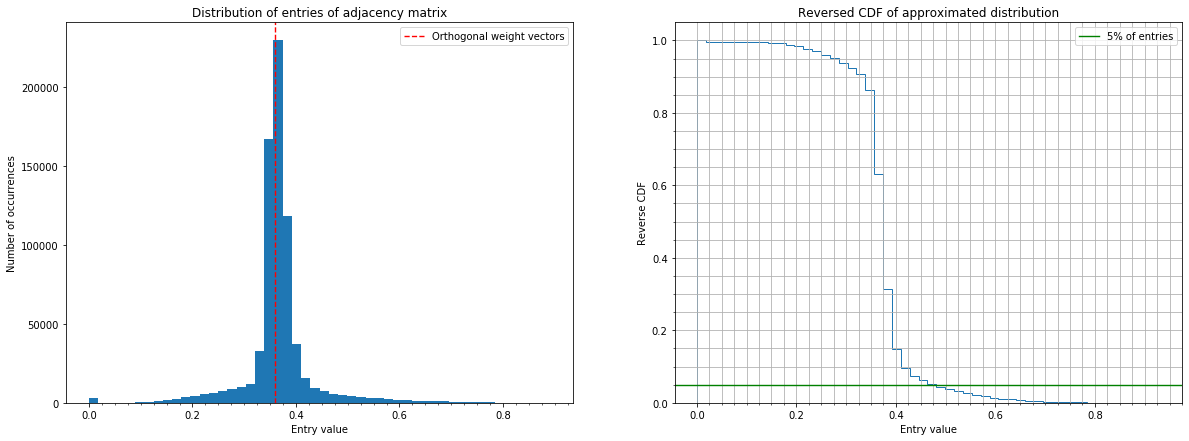

In [45]:
adjacency, weight_norms, kernel_width = statistics.weight_dist(dir_name, epochs, model_class, 'fc1', bias=False)

In [46]:
s = Snapshots(dir_name, epochs, model_class, bias=False)

In [47]:
getattr(s.models[10], 'fc1').get_weights().shape

torch.Size([256, 12544])

In [48]:
dir_name_mod = "out/models/Conv2_30_unbiased_22-10-2019_15:06:42"
epochs = list(range(11))
model_class_mod = Conv2_30
s_mod = Snapshots(dir_name_mod, epochs, model_class_mod, bias=False)

In [49]:
other_weights = s_mod.get_weights('fc1')[10]
other_weights.shape

torch.Size([30, 12544])

In [50]:
inner_products = s.compute_ips_with('fc1', other_weights, 10)

In [51]:
def transform(inner_products, kernel_width):
    ips_mod = -0.5 * (inner_products - 1)
    adjacency = np.exp(-ips_mod ** 2 / (kernel_width ** 2))
    return adjacency

In [52]:
adj_mod = transform(inner_products, kernel_width).numpy()

In [208]:
adj_mod.shape

torch.Size([30, 256])

In [209]:
values, indices = adj_mod.max(dim=1)

In [200]:
torch.arange(30)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [211]:
diff = (indices - torch.arange(30)).numpy()

In [213]:
indices = np.argsort(weight_norms_mod[10])

In [214]:
indices

array([26,  0, 20,  9,  1, 11,  8,  3, 23, 27, 28, 29, 24, 17, 13, 18, 25,
       12,  5, 16,  6, 14, 10, 19, 22,  4, 15,  7, 21,  2])

In [155]:
initial_w = s.get_weights('fc1')[0]
initial_w_mod = s_mod.get_weights('fc1')[0]

In [162]:
i = 9
print(initial_w[i][:5])
print(initial_w_mod[i][:5])

tensor([ 0.0024, -0.0089,  0.0062,  0.0005,  0.0057])
tensor([ 0.0024, -0.0089,  0.0062,  0.0005,  0.0057])


In [215]:
c = indices[:14].copy()
c.sort()
c

array([ 0,  1,  3,  8,  9, 11, 17, 20, 23, 24, 26, 27, 28, 29])

In [216]:
np.argwhere(diff == 0).flatten()

array([ 0,  1,  3,  8,  9, 11, 17, 20, 23, 24, 26, 27, 28, 29])

In [218]:
print(diff)
print("Ratio of elements with same initialization that have not moved: {:.3f}".format((diff == 0).sum() / diff.size))

[  0   0 187   0 173  13  68 111   0   0 131   0 118  24 171  20  36   0
 181 107   0 224 164   0   0  -2   0   0   0   0]
Ratio of elements with same initialization that have not moved: 0.467


In [37]:
cut_off = adj_mod.max(axis=1).min()

In [38]:
node_selection = c.tolist()
adj_mod[node_selection].max(axis=1)

NameError: name 'c' is not defined

In [231]:
mask = np.ones(adj_mod.shape[0], dtype=bool)
mask[adj] = False

adj_mod[mask].max(axis=1)

array([0.71409976, 0.5838594 , 0.66689634, 0.66640115, 0.59131384,
       0.5849505 , 0.73873085, 0.5833552 , 0.6164704 , 0.6134408 ,
       0.64643043, 0.44935384, 0.63302135, 0.6423692 , 0.6084    ,
       0.68819964], dtype=float32)

In [254]:
max_ip = adj_mod.max(axis=1)
max_ip[max_ip > 0.57].sum() / max_ip.size

0.5946210225423177

In [53]:
cut_off = 0.57

In [61]:
adj_mod[adj_mod < cut_off] = 0.

In [273]:
for node_idx in range(adj_mod.shape[0]):
    if node_idx not in node_selection:
        n_neighbors = (adj_mod[node_idx] != 0).sum()
        print(f"Node {node_idx} has {n_neighbors} neighbors")

Node 2 has 5 neighbors
Node 4 has 1 neighbors
Node 5 has 4 neighbors
Node 6 has 3 neighbors
Node 7 has 1 neighbors
Node 10 has 5 neighbors
Node 12 has 7 neighbors
Node 13 has 1 neighbors
Node 14 has 2 neighbors
Node 15 has 2 neighbors
Node 16 has 2 neighbors
Node 18 has 0 neighbors
Node 19 has 2 neighbors
Node 21 has 6 neighbors
Node 22 has 2 neighbors
Node 25 has 4 neighbors


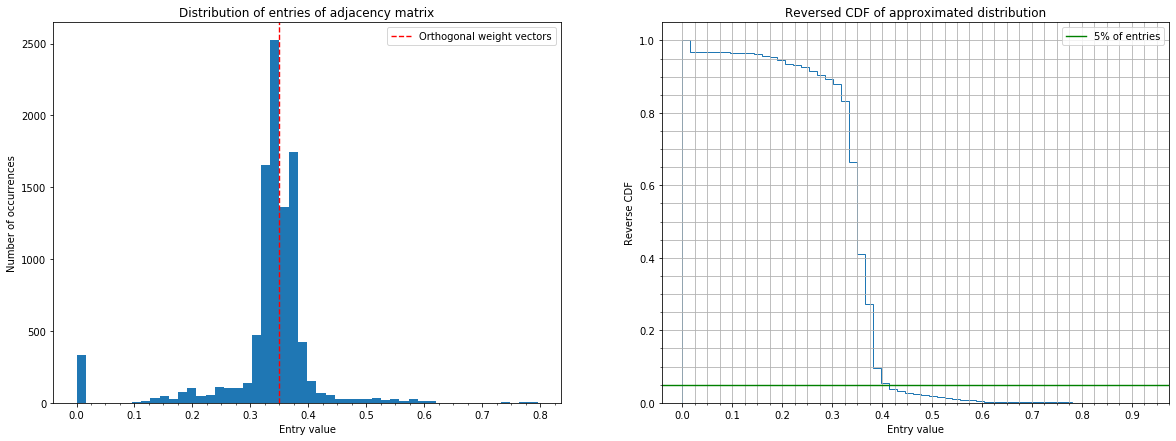

In [62]:
_, weight_norms_mod, _ = statistics.weight_dist(dir_name_mod, epochs, model_class_mod, 'fc1', bias=False)

In [63]:
weight_norms_mod.shape

(11, 30)

In [64]:
import json

with open("viz/nn_graph.json", 'r') as fp:
    graph = json.load(fp)

In [65]:
graph

{'nodes': [{'id': '0',
   'fraction': {'0': 0.575,
    '1': 0.945,
    '2': 1.174,
    '3': 1.372,
    '4': 1.553,
    '5': 1.721,
    '6': 1.878,
    '7': 2.031,
    '8': 2.174,
    '9': 2.304,
    '10': 2.428}},
  {'id': '1',
   'fraction': {'0': 0.576,
    '1': 0.962,
    '2': 1.194,
    '3': 1.41,
    '4': 1.621,
    '5': 1.821,
    '6': 2.009,
    '7': 2.183,
    '8': 2.342,
    '9': 2.488,
    '10': 2.622}},
  {'id': '2',
   'fraction': {'0': 0.578,
    '1': 1.053,
    '2': 1.303,
    '3': 1.526,
    '4': 1.742,
    '5': 1.948,
    '6': 2.137,
    '7': 2.311,
    '8': 2.469,
    '9': 2.609,
    '10': 2.728}},
  {'id': '3',
   'fraction': {'0': 0.577,
    '1': 0.594,
    '2': 0.594,
    '3': 0.594,
    '4': 0.594,
    '5': 0.594,
    '6': 0.594,
    '7': 0.594,
    '8': 0.594,
    '9': 0.594,
    '10': 0.594}},
  {'id': '4',
   'fraction': {'0': 0.579,
    '1': 0.595,
    '2': 0.595,
    '3': 0.907,
    '4': 0.907,
    '5': 0.907,
    '6': 0.907,
    '7': 0.907,
    '8': 0.907,
  

In [66]:
start_idx = 256

n_epochs = adjacency.shape[0]
n_nodes = adjacency.shape[1]
new_nodes = adj_mod.shape[0]

for node_id in range(new_nodes):
    node_id_mod = node_id + start_idx
    norms = {str(epoch): float("{:.3f}".format(weight_norms_mod[epoch, node_id])) for epoch in range(n_epochs)}
    node_entry = {"id": str(node_id_mod), "fraction": norms}
    graph["nodes"].append(node_entry)

for i in range(new_nodes):
    for j in range(n_nodes):
        edge_weight = adj_mod[i, j]
        if edge_weight:
            i_mod = i + start_idx
            edge_entry = {"source": str(i_mod), "target": str(j), "value": float("{:.3f}".format(edge_weight)),
                          "year": n_epochs-1}
            graph["links"].append(edge_entry)


graph_fname = os.path.join(common.VIZ_DIR, "nn_graph.json")
with open(graph_fname, 'w') as fp:
    json.dump(graph, fp, indent=4)

### Pruning Conv2

In [0]:
layers = ['fc1', 'fc2']
exp_acc, exp_fps, pruning_accuracies, pruning_fps = cifar_pruning(testloader, layers, pruning_ratio=0.9, include_random=False, n_rounds=2, save_results=True)

Pruning using: max_fp_pruning

Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)

Pruning round: [ 10/230 (4%)]

Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:  

In [72]:
fname_exp_acc = "out/metrics/pruning/Conv2_fc1_random_pruning_0.9_acc_15-10-2019_16:29:12.npy"
fname_exp_fps = "out/metrics/pruning/Conv2_fc1_random_pruning_0.9_fp_15-10-2019_16:29:13.npy"
fname_pruning_acc = "out/metrics/pruning/Conv2_fc1_combined_0.9_acc_13-10-2019_14:17:35.npy"
fname_pruning_fps = "out/metrics/pruning/Conv2_fc1_combined_0.9_fp_13-10-2019_14:17:35.npy"

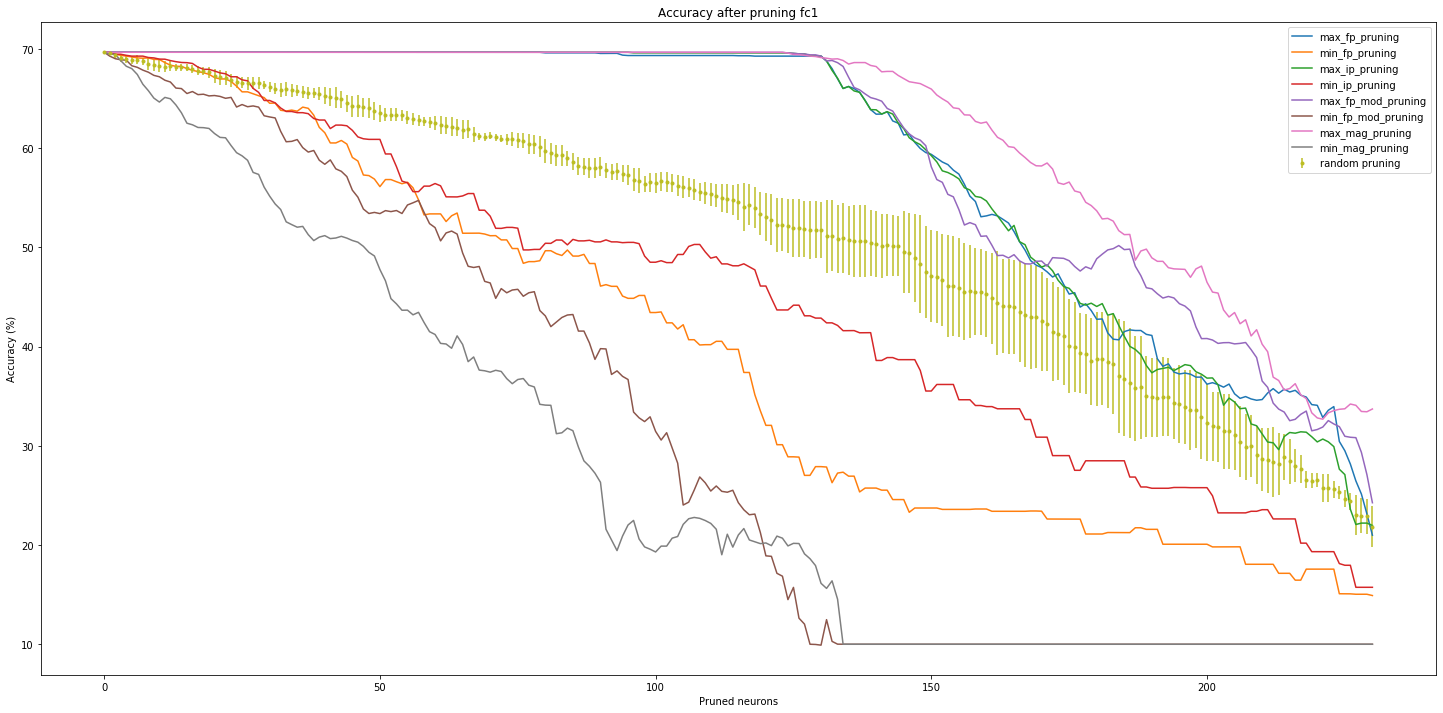

In [75]:
helpers.draw_acc_plot('fc1', fname_exp_acc, fname_pruning_acc, fig_name="Conv2_fc1_combined_0.9_acc_13-10-2019_14:17:35")

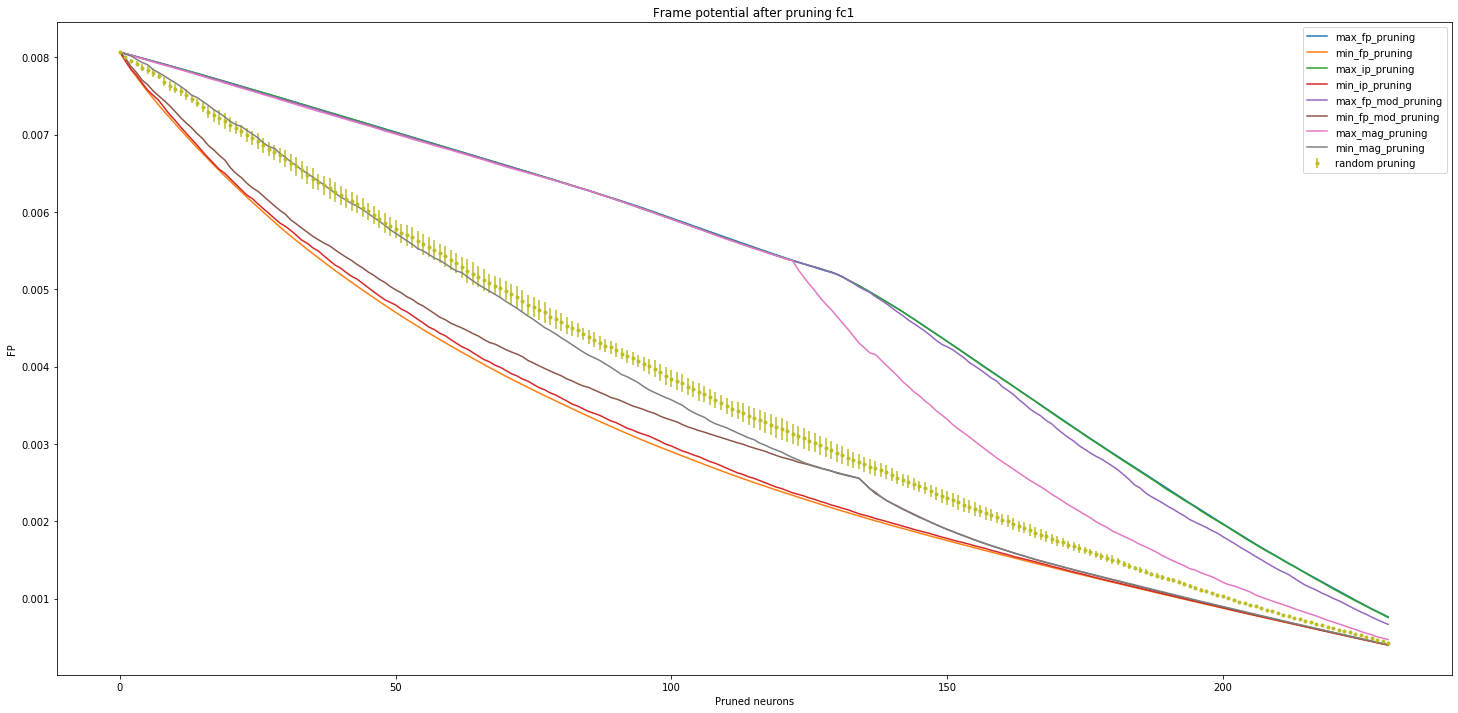

In [77]:
helpers.draw_fps_plot('fc1', fname_exp_fps, fname_pruning_fps, fig_name="Conv2_fc1_combined_0.9_fp_13-10-2019_14:17:35")

In [78]:
fname_exp_acc = "out/metrics/pruning/Conv2_fc2_random_pruning_0.9_acc_15-10-2019_18:36:32.npy"
fname_exp_fps = "out/metrics/pruning/Conv2_fc2_random_pruning_0.9_fp_15-10-2019_18:36:32.npy"
fname_pruning_acc = "out/metrics/pruning/Conv2_fc2_combined_0.9_acc_13-10-2019_15:30:05.npy"
fname_pruning_fps = "out/metrics/pruning/Conv2_fc2_combined_0.9_fp_13-10-2019_15:30:05.npy"

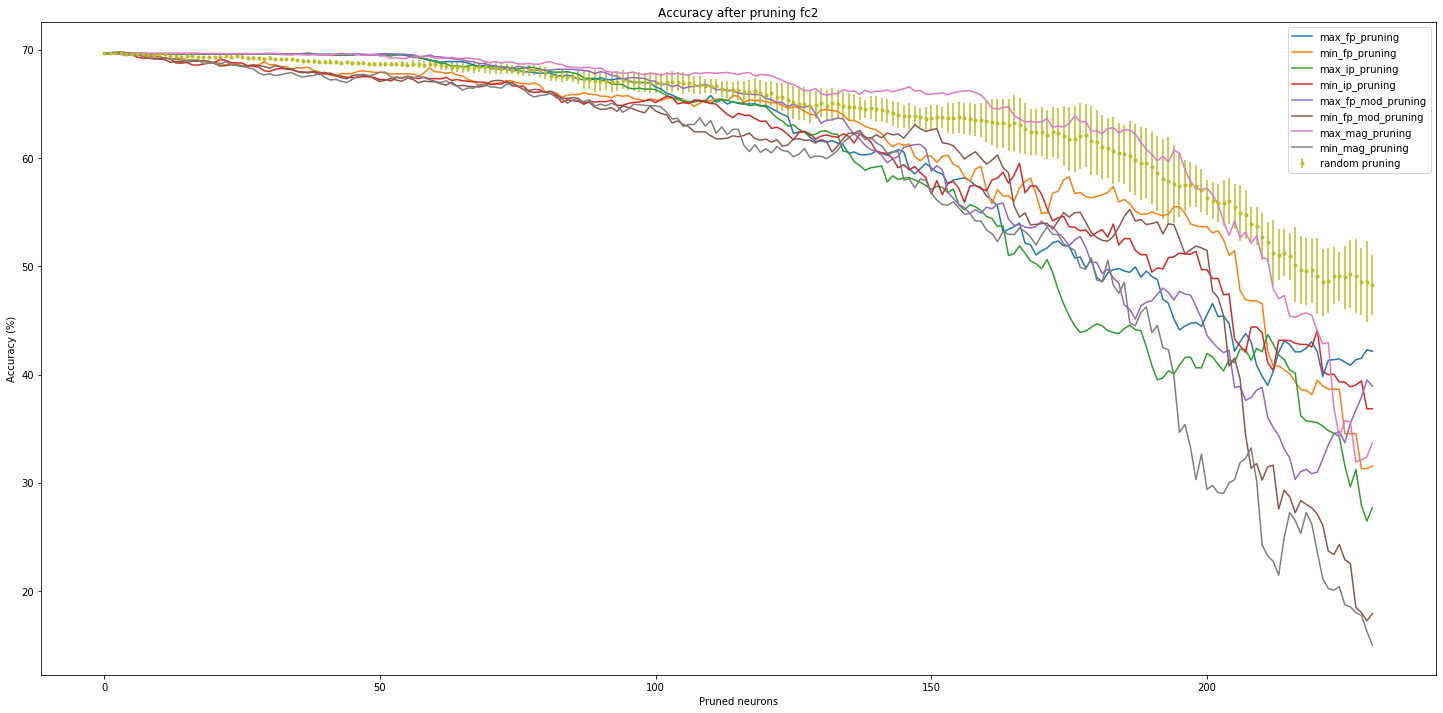

In [79]:
helpers.draw_acc_plot('fc2', fname_exp_acc, fname_pruning_acc, fig_name="Conv2_fc2_combined_0.9_acc_13-10-2019_15:30:05")

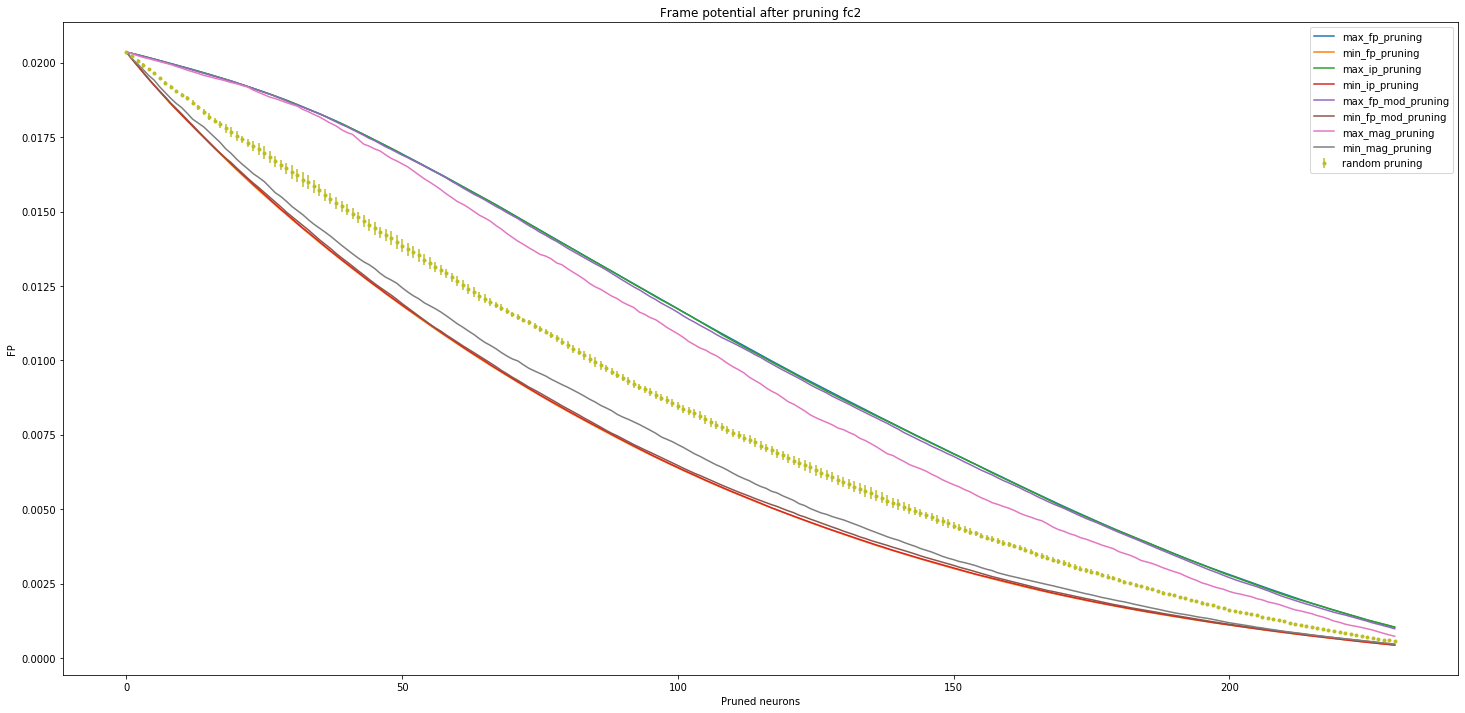

In [80]:
helpers.draw_fps_plot('fc2', fname_exp_fps, fname_pruning_fps, fig_name="Conv2_fc2_combined_0.9_fp_13-10-2019_15:30:05")

In [0]:
layers = ['conv1', 'conv2']
exp_acc, exp_fps, pruning_accuracies, pruning_fps = cifar_pruning(testloader, layers, pruning_ratio=0.9, include_random=True, n_rounds=5, save_results=True)

Random pruning experiment:

Random pruning experiment N° 1

Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2000, Accuracy:   6957/ 10000 (70%)


Test set: Average loss: 2.1510, Accuracy:   6914/ 10000 (69%)


Test set: Average loss: 2.1426, Accuracy:   6914/ 10000 (69%)


Test set: Average loss: 2.0882, Accuracy:   6914/ 10000 (69%)


Test set: Average loss: 2.0720, Accuracy:   6888/ 10000 (69%)


Test set: Average loss: 2.0417, Accuracy:   6882/ 10000 (69%)


Test set: Average loss: 2.0114, Accuracy:   6844/ 10000 (68%)


Test set: Average loss: 1.9873, Accuracy:   6827/ 10000 (68%)


Test set: Average loss: 1.9550, Accuracy:   6818/ 10000 (68%)


Test set: Average loss: 1.9136, Accuracy:   6798/ 10000 (68%)

Pruning round: [ 10/ 57 (18%)]

Test set: Average loss: 1.8687, Accuracy:   6813/ 10000 (68%)


Test set: Average loss: 1.8958, Accuracy:   6792/ 10000 (68%)


Test set: Average loss: 1.9100, Accuracy:   6774/ 10000 (68%)


Test set: Ave

In [0]:
fname_exp_acc = "out/metrics/pruning/Conv2_conv1_random_pruning_0.9_acc_13-10-2019_15:41:15.npy"
fname_exp_fps = "out/metrics/pruning/Conv2_conv1_random_pruning_0.9_fp_13-10-2019_15:41:15.npy"
fname_pruning_acc = "out/metrics/pruning/Conv2_conv1_combined_0.9_acc_13-10-2019_15:59:18.npy"
fname_pruning_fps = "out/metrics/pruning/Conv2_conv1_combined_0.9_fp_13-10-2019_15:59:18.npy"

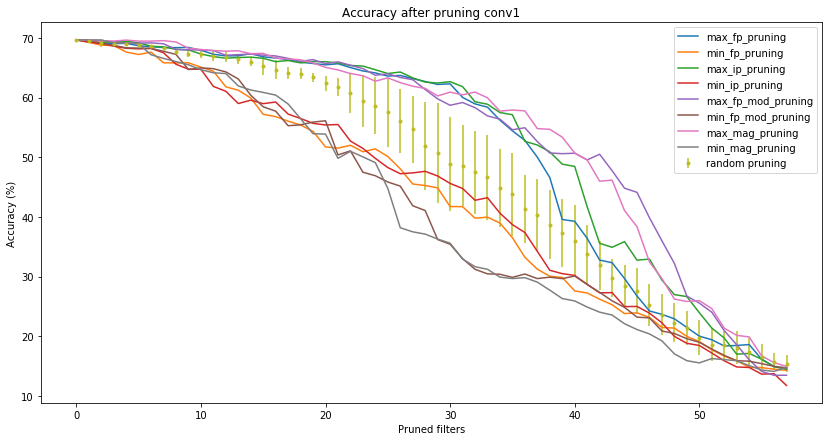

In [0]:
helpers.draw_acc_plot('conv1', fname_exp_acc, fname_pruning_acc, figsize=(14, 7), fig_name="Conv2_conv1_combined_0.9_acc_13-10-2019_15:59:18")

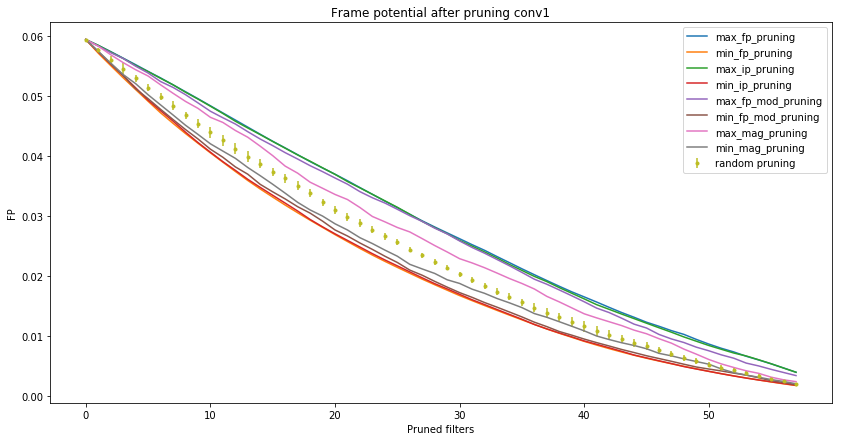

In [0]:
helpers.draw_fps_plot('conv1', fname_exp_fps, fname_pruning_fps, figsize=(14, 7), fig_name="Conv2_conv1_combined_0.9_fp_13-10-2019_15:59:18")

In [0]:
fname_exp_acc = "out/metrics/pruning/Conv2_conv2_random_pruning_0.9_acc_13-10-2019_16:10:29.npy"
fname_exp_fps = "out/metrics/pruning/Conv2_conv2_random_pruning_0.9_fp_13-10-2019_16:10:29.npy"
fname_pruning_acc = "out/metrics/pruning/Conv2_conv2_combined_0.9_acc_13-10-2019_16:28:55.npy"
fname_pruning_fps = "out/metrics/pruning/Conv2_conv2_combined_0.9_fp_13-10-2019_16:28:55.npy"

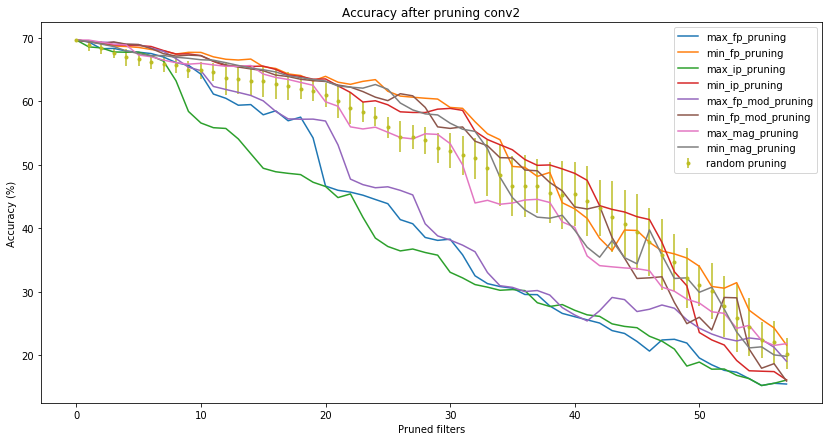

In [0]:
helpers.draw_acc_plot('conv2', fname_exp_acc, fname_pruning_acc, figsize=(14, 7), fig_name="Conv2_conv2_combined_0.9_acc_13-10-2019_16:28:55")

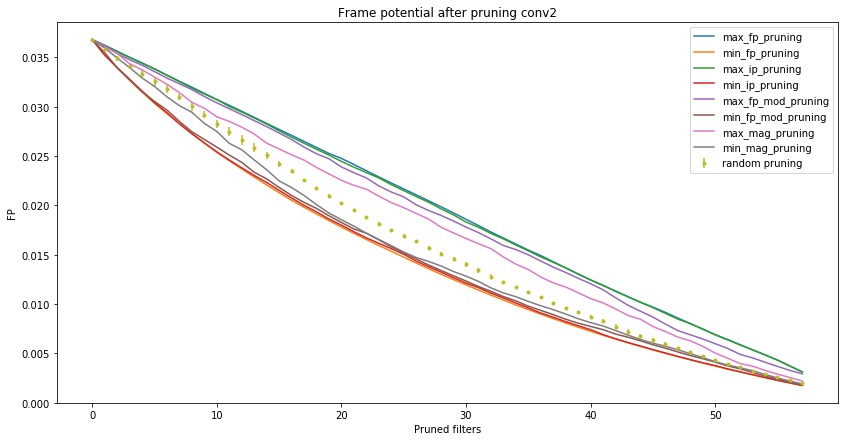

In [0]:
helpers.draw_fps_plot('conv2', fname_exp_fps, fname_pruning_fps, figsize=(14, 7), fig_name="Conv2_conv2_combined_0.9_fp_13-10-2019_16:28:55")

#### Pruning schedules

In [20]:
layers = ['fc1']
pruning = prune.max_mag_pruning
pruning_ratios = [0.3, 0.6, 0.9]
accuracies, frame_potentials = cifar_scheduling(testloader, layers, pruning, pruning_ratios, save_results=True)


Test set: Average loss: 2.3042, Accuracy:    990/ 10000 (10%)


Test set: Average loss: 2.3049, Accuracy:    880/ 10000 (9%)

Evaluating model accuracies [  1/ 75]

Test set: Average loss: 1.8126, Accuracy:   3434/ 10000 (34%)


Test set: Average loss: 1.8478, Accuracy:   3241/ 10000 (32%)


Test set: Average loss: 1.8126, Accuracy:   3434/ 10000 (34%)

Evaluating model accuracies [  2/ 75]

Test set: Average loss: 1.6719, Accuracy:   4033/ 10000 (40%)


Test set: Average loss: 1.6899, Accuracy:   3982/ 10000 (40%)


Test set: Average loss: 1.6768, Accuracy:   4009/ 10000 (40%)

Evaluating model accuracies [  3/ 75]

Test set: Average loss: 1.5763, Accuracy:   4366/ 10000 (44%)


Test set: Average loss: 1.6074, Accuracy:   4342/ 10000 (43%)


Test set: Average loss: 1.5904, Accuracy:   4328/ 10000 (43%)

Evaluating model accuracies [  4/ 75]

Test set: Average loss: 1.5108, Accuracy:   4517/ 10000 (45%)


Test set: Average loss: 1.5233, Accuracy:   4467/ 10000 (45%)


Test set: Averag

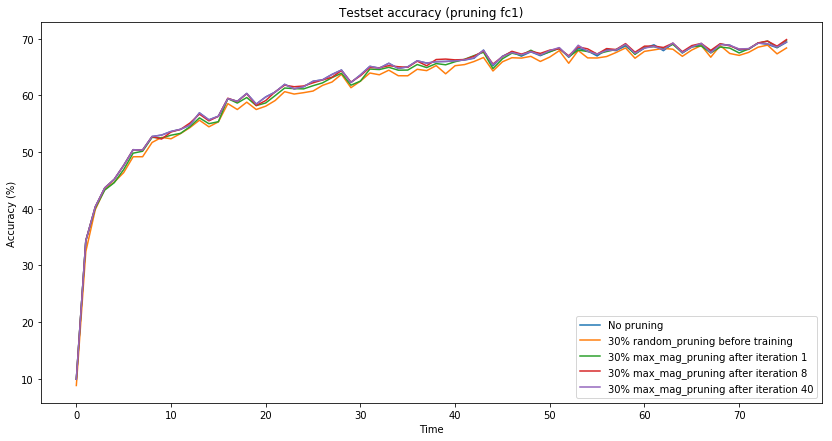

In [30]:
acc_fname = "out/metrics/pruning/Conv2_fc1_scheduled-pruning_0.3_acc_15-10-2019_10:47:44.npy"
draw_sched_plot('fc1', acc_fname, "max_mag_pruning", pruning_ratio=0.3, figsize=(14, 7), fig_name="Conv2_fc1_scheduled-pruning_0.3_acc_15-10-2019_10:47:44")

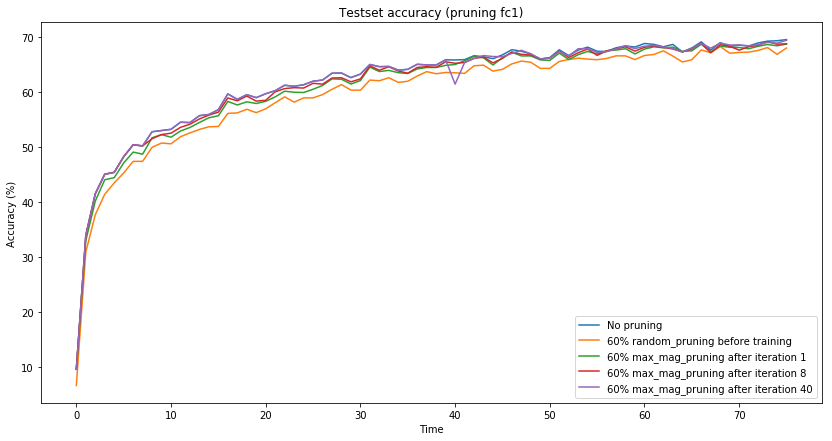

In [31]:
acc_fname = "out/metrics/pruning/Conv2_fc1_scheduled-pruning_0.6_acc_15-10-2019_10:15:57.npy"
draw_sched_plot('fc1', acc_fname, "max_mag_pruning", pruning_ratio=0.6, figsize=(14, 7), fig_name="Conv2_fc1_scheduled-pruning_0.6_acc_15-10-2019_10:15:57")

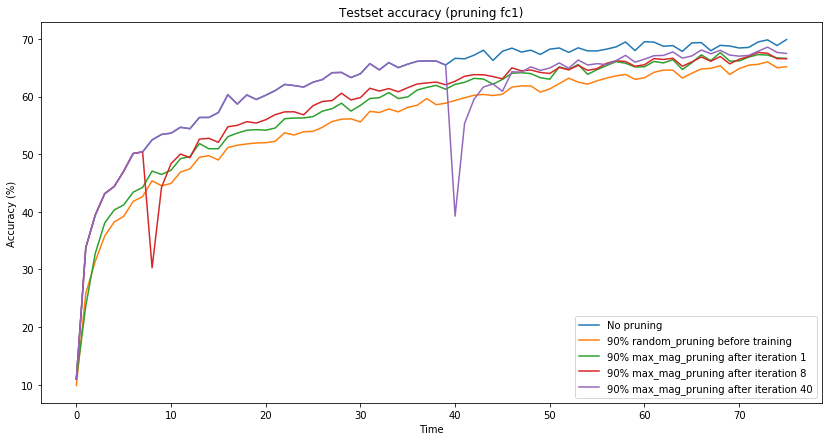

In [32]:
acc_fname = "out/metrics/pruning/Conv2_fc1_scheduled-pruning_0.9_acc_15-10-2019_11:05:46.npy"
draw_sched_plot('fc1', acc_fname, "max_mag_pruning", pruning_ratio=0.9, figsize=(14, 7), fig_name="Conv2_fc1_scheduled-pruning_0.9_acc_15-10-2019_11:05:46")

In [25]:
layers = ['fc2']
pruning = prune.max_mag_pruning
pruning_ratios = [0.3, 0.6, 0.9]
accuracies, frame_potentials = cifar_scheduling(testloader, layers, pruning, pruning_ratios, save_results=True)


Test set: Average loss: 2.3026, Accuracy:   1199/ 10000 (12%)


Test set: Average loss: 2.3027, Accuracy:   1224/ 10000 (12%)

Evaluating model accuracies [  1/ 75]

Test set: Average loss: 1.8262, Accuracy:   3334/ 10000 (33%)


Test set: Average loss: 1.8714, Accuracy:   3217/ 10000 (32%)


Test set: Average loss: 1.9137, Accuracy:   3072/ 10000 (31%)

Evaluating model accuracies [  2/ 75]

Test set: Average loss: 1.7107, Accuracy:   3914/ 10000 (39%)


Test set: Average loss: 1.6954, Accuracy:   3990/ 10000 (40%)


Test set: Average loss: 1.7192, Accuracy:   3915/ 10000 (39%)

Evaluating model accuracies [  3/ 75]

Test set: Average loss: 1.5736, Accuracy:   4448/ 10000 (44%)


Test set: Average loss: 1.6033, Accuracy:   4384/ 10000 (44%)


Test set: Average loss: 1.6197, Accuracy:   4240/ 10000 (42%)

Evaluating model accuracies [  4/ 75]

Test set: Average loss: 1.5050, Accuracy:   4569/ 10000 (46%)


Test set: Average loss: 1.5182, Accuracy:   4537/ 10000 (45%)


Test set: Avera

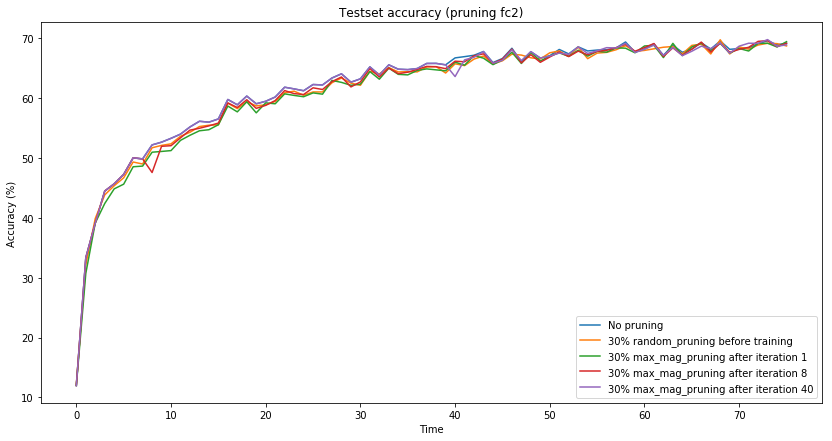

In [33]:
acc_fname = "out/metrics/pruning/Conv2_fc2_scheduled-pruning_0.3_acc_15-10-2019_11:28:03.npy"
draw_sched_plot('fc2', acc_fname, "max_mag_pruning", pruning_ratio=0.3, figsize=(14, 7), fig_name="Conv2_fc2_scheduled-pruning_0.3_acc_15-10-2019_11:28:03")

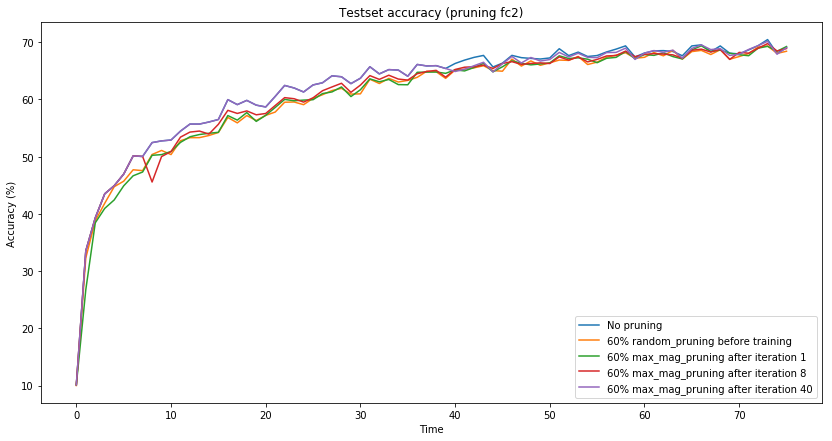

In [34]:
acc_fname = "out/metrics/pruning/Conv2_fc2_scheduled-pruning_0.6_acc_15-10-2019_11:45:38.npy"
draw_sched_plot('fc2', acc_fname, "max_mag_pruning", pruning_ratio=0.6, figsize=(14, 7), fig_name="Conv2_fc2_scheduled-pruning_0.6_acc_15-10-2019_11:45:38")

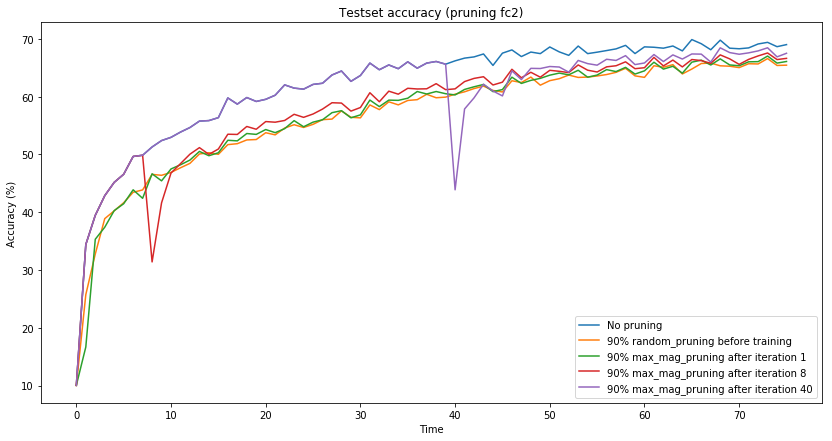

In [35]:
acc_fname = "out/metrics/pruning/Conv2_fc2_scheduled-pruning_0.9_acc_15-10-2019_12:03:41.npy"
draw_sched_plot('fc2', acc_fname, "max_mag_pruning", pruning_ratio=0.9, figsize=(14, 7), fig_name="Conv2_fc2_scheduled-pruning_0.9_acc_15-10-2019_12:03:41")

## Subspace analysis

In [128]:
def save_results(output_dir, layers):
    s = Snapshots(output_dir)
    fp_paths = {}
    ip_paths = {}
    norms_paths = {}
    graph_specs = {}
    for layer in layers:
        fp_path, ip_path, norms_path = s.save_computed_metrics(layer)
        fp_paths[layer] = fp_path
        ip_paths[layer] = ip_path
        norms_paths[layer] = norms_path
        graph_specs[layer] = s.create_adjacency(layer)
        
    return fp_paths, ip_paths, norms_paths, graph_specs

In [129]:
# out/Conv2-28_11_2019-10:21:39
# out/Conv4-28_11_2019-18:17:15
# out/Conv6-28_11_2019-18:23:42
# layers = ["conv1", "conv2", "conv3", "conv4", "conv5", "conv6", "fc1", "fc2", "fc3"]

output_dir = "out/Conv2-28_11_2019-10:21:39"  # changeme
layers = ["conv2", "fc1", "fc2"]

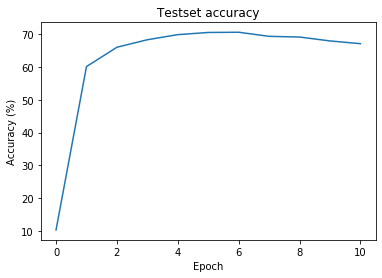

In [130]:
helpers.plot_test_acc(output_dir)

In [131]:
fp_paths, ip_paths, norms_paths, graph_specs = save_results(output_dir, layers)

Saved frame potentials to: out/Conv2-28_11_2019-10:21:39/metrics/training/frame_potentials-conv2.npy
Saved inner products to: out/Conv2-28_11_2019-10:21:39/metrics/training/inner_products-conv2.npy
Saved weight vector norms to: out/Conv2-28_11_2019-10:21:39/metrics/training/weight_norms-conv2.npy
Saved adjacency matrix to: out/Conv2-28_11_2019-10:21:39/metrics/training/adjacency-conv2.npy
Saved frame potentials to: out/Conv2-28_11_2019-10:21:39/metrics/training/frame_potentials-fc1.npy
Saved inner products to: out/Conv2-28_11_2019-10:21:39/metrics/training/inner_products-fc1.npy
Saved weight vector norms to: out/Conv2-28_11_2019-10:21:39/metrics/training/weight_norms-fc1.npy
Saved adjacency matrix to: out/Conv2-28_11_2019-10:21:39/metrics/training/adjacency-fc1.npy
Saved frame potentials to: out/Conv2-28_11_2019-10:21:39/metrics/training/frame_potentials-fc2.npy
Saved inner products to: out/Conv2-28_11_2019-10:21:39/metrics/training/inner_products-fc2.npy
Saved weight vector norms to: 

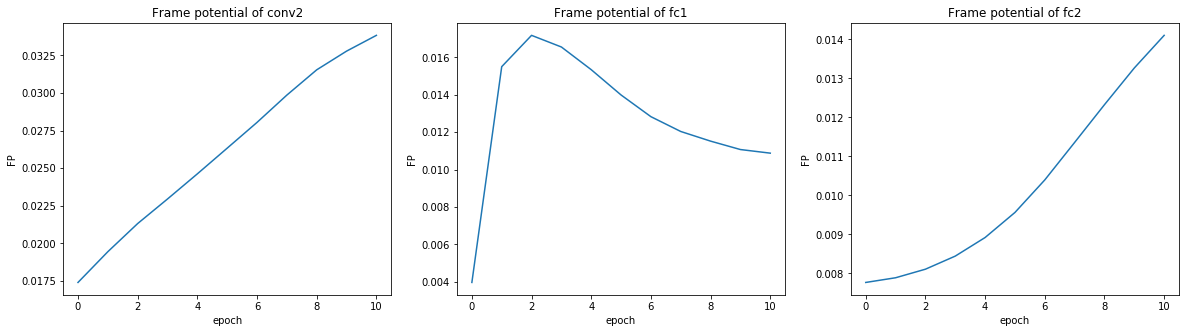

In [132]:
helpers.plot_train_fps(fp_paths, layers)

In [133]:
layer = "fc1"  # e.g. conv1, fc1, fc2, etc.
weight_norms = np.load(norms_paths[layer])
adjacency, kernel_width = graph_specs[layer]

## Analysis part

Epoch N° 0


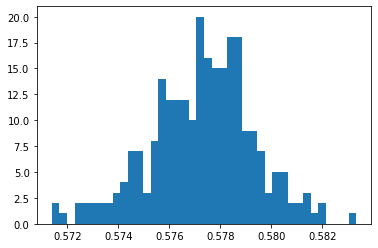

Epoch N° 1


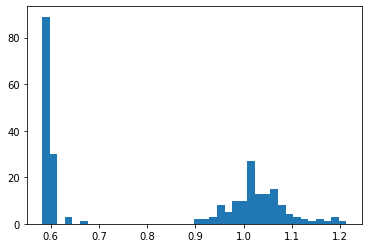

Epoch N° 2


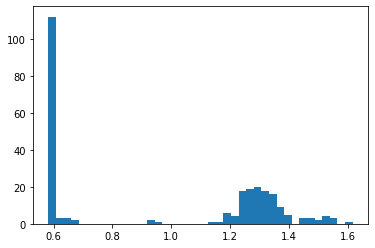

Epoch N° 3


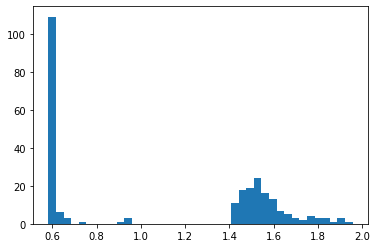

Epoch N° 4


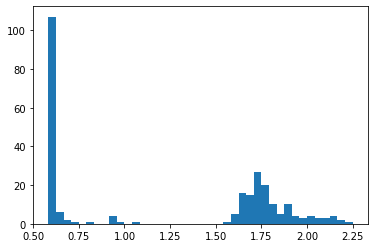

Epoch N° 5


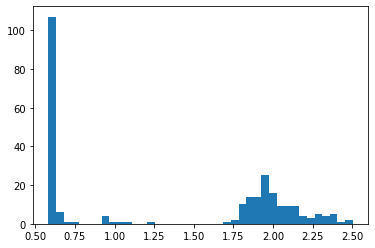

Epoch N° 6


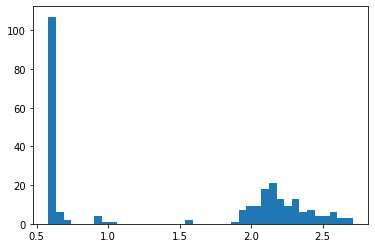

Epoch N° 7


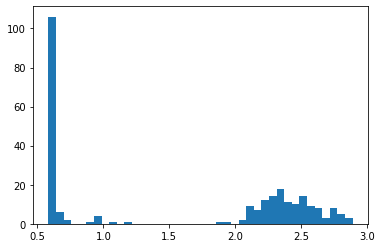

Epoch N° 8


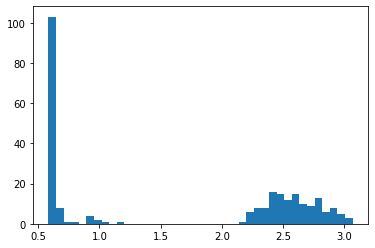

Epoch N° 9


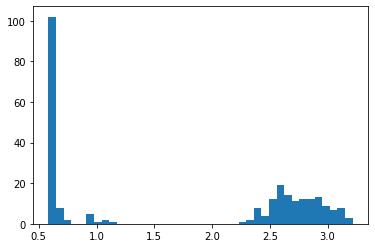

Epoch N° 10


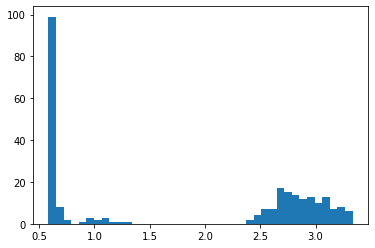

In [127]:
for i in range(weight_norms.shape[0]):
    print("Epoch N°", i)
    plt.hist(weight_norms[i], bins=40)
    plt.show()

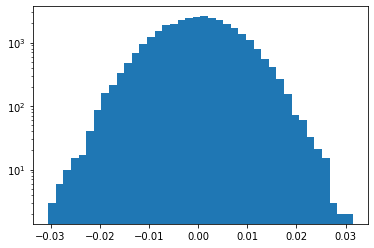

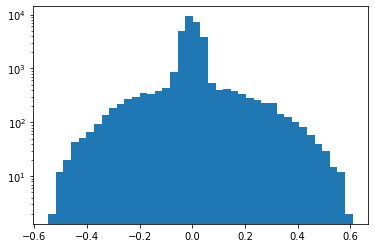

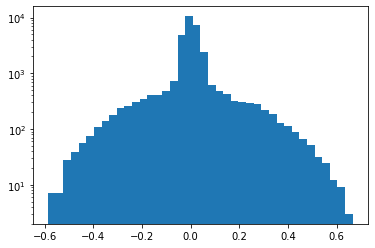

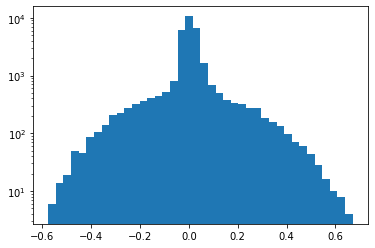

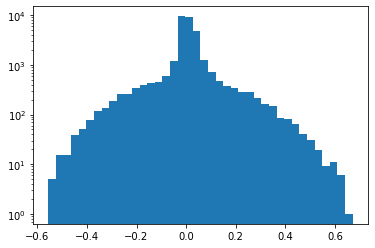

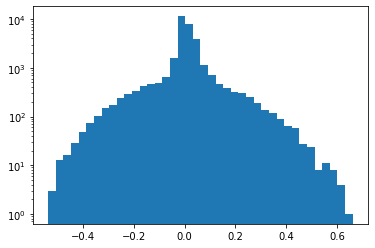

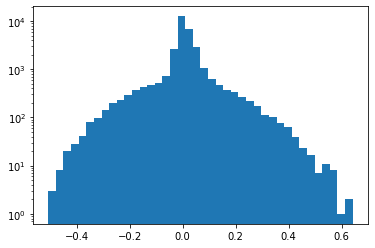

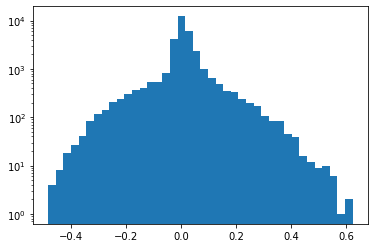

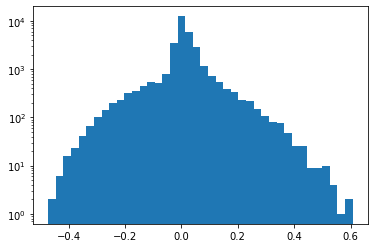

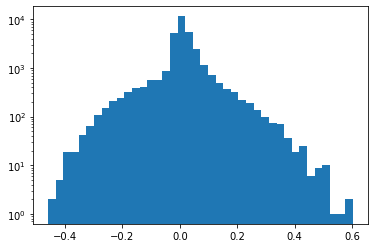

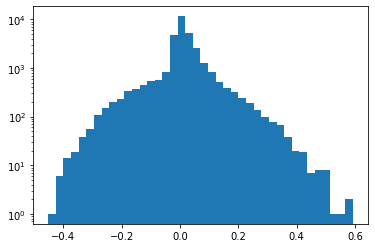

In [11]:
ips = np.load(output_dir + "/metrics/training/inner_products-fc1.npy")
weights = []
for i in range(ips.shape[0]):
    weights_i = []
    for j in range(ips.shape[1]):
        for k in range(ips.shape[2]):
            if j < k:
                weights_i.append(ips[i, j, k])
    weights.append(weights_i)
            
for i in range(ips.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    hist = plt.hist(weights[i], bins=40)
    ax.set_yscale('log')
    plt.show()

## End of analysis part

In [134]:
trained_nodes = np.argwhere(weight_norms[6] > 0.75).flatten().tolist()
untrained_nodes = np.argwhere(weight_norms[6] <= 0.75).flatten().tolist()

In [135]:
trained_len = len(trained_nodes)
untrained_len = len(untrained_nodes)

In [137]:
s = Snapshots(output_dir)
epochs = 6
w_raw = s.get_weights("fc1")
w = torch.zeros(epochs, w_raw.shape[1], w_raw.shape[2])
for epoch in range(epochs):
    w[epoch] = F.normalize(w_raw[epoch], p=2, dim=1)

In [138]:
w_selected = w[:, trained_nodes, :]
w_not_selected = w[:, untrained_nodes, :]

In [139]:
w_selected.shape

torch.Size([6, 141, 16384])

In [140]:
u = np.zeros((w_selected.shape[0], w_selected.shape[2], w_selected.shape[1]))
s = np.zeros((w_selected.shape[0], trained_len))

In [141]:
for epoch in range(w_selected.shape[0]):
    print("Epoch", epoch)
    w_epoch = w_selected[epoch].numpy().T
    u_epoch, s_epoch, _ = np.linalg.svd(w_epoch, full_matrices=False)
    u[epoch] = u_epoch
    s[epoch] = s_epoch

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


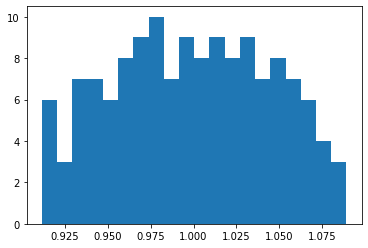

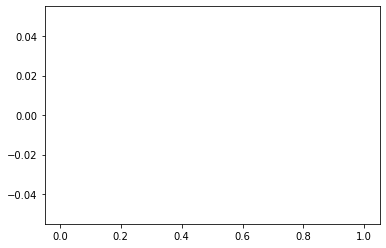

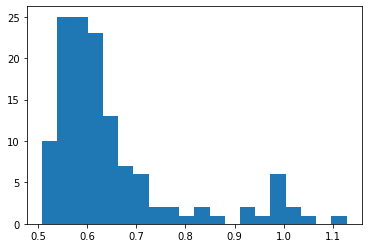

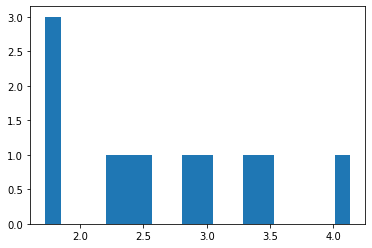

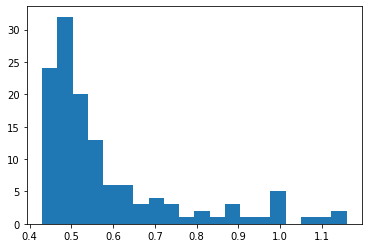

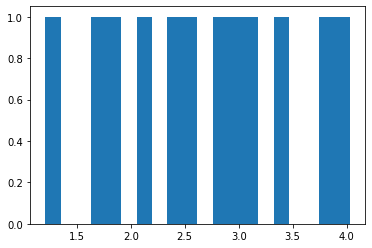

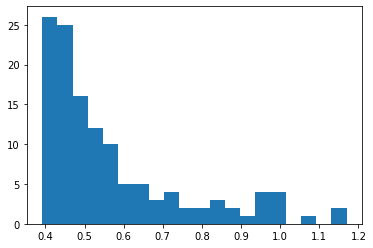

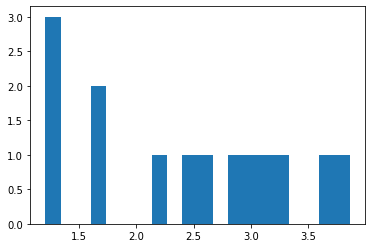

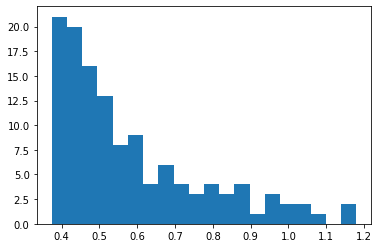

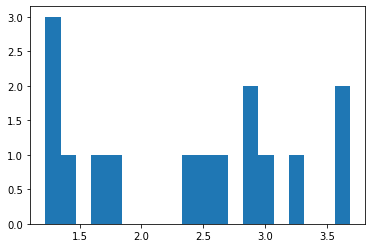

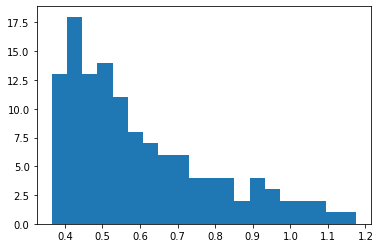

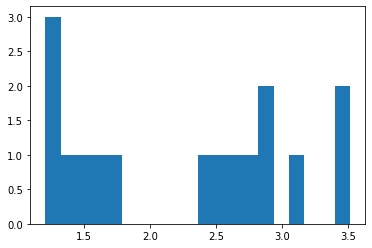

In [142]:
for epoch in range(s.shape[0]):
    selected = s[epoch]
    small_selected = selected[selected < 1.2] # explain why
    big_selected = selected[selected >= 1.2]
    plt.hist(small_selected, bins=20)
    plt.show()
    plt.hist(big_selected, bins=20)
    plt.show()

In [143]:
u_rest = np.zeros((w_not_selected.shape[0], w_not_selected.shape[2], w_not_selected.shape[1]))
s_rest = np.zeros((w_not_selected.shape[0], untrained_len))

In [144]:
for epoch in range(w_not_selected.shape[0]):
    print("Epoch", epoch)
    w_epoch = w_not_selected[epoch].numpy().T
    u_epoch, s_epoch, _ = np.linalg.svd(w_epoch, full_matrices=False)
    u_rest[epoch] = u_epoch
    s_rest[epoch] = s_epoch

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


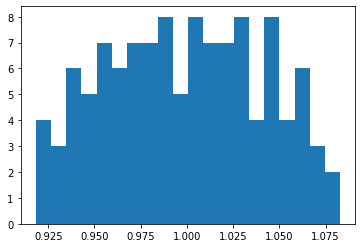

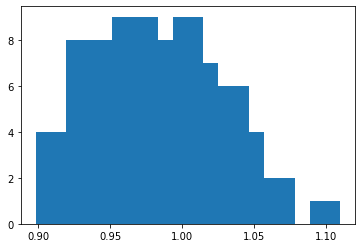

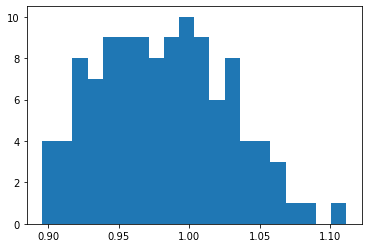

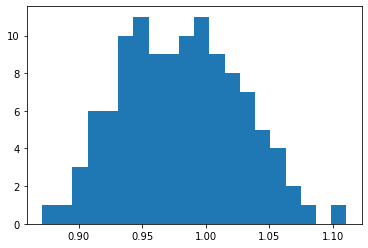

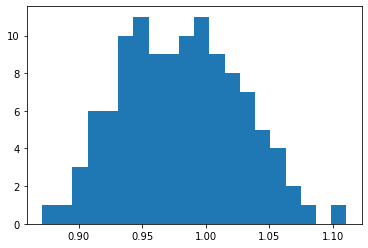

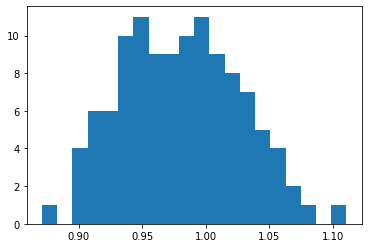

In [147]:
for epoch in range(s_rest.shape[0]):
    selected = s_rest[epoch]
    selected = selected[(0.8 < selected) & (selected < 1.2)] # explain why
    plt.hist(selected, bins=20)
    plt.show()

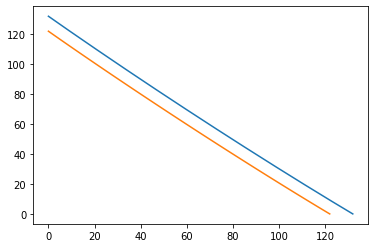

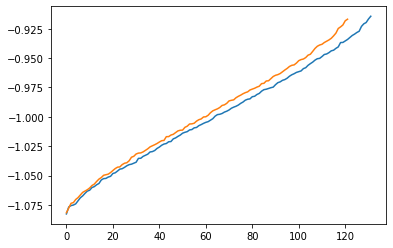

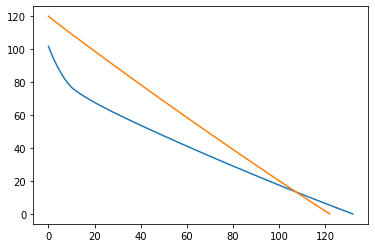

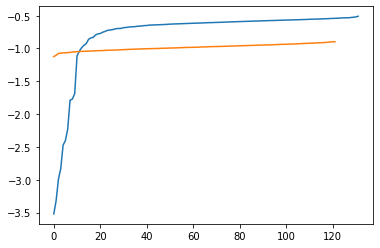

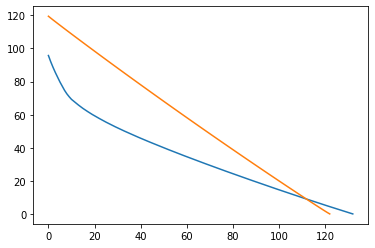

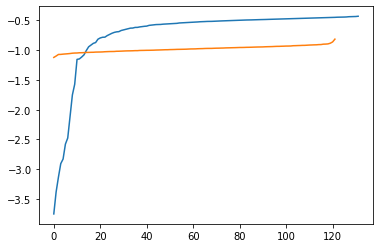

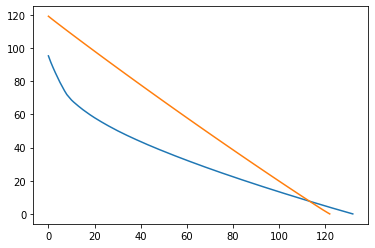

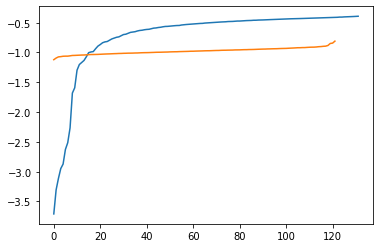

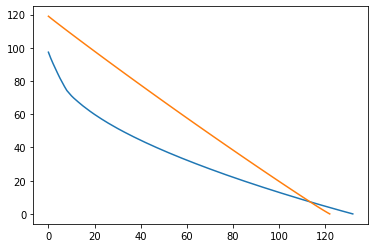

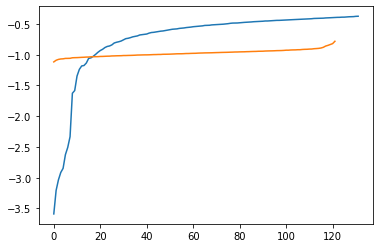

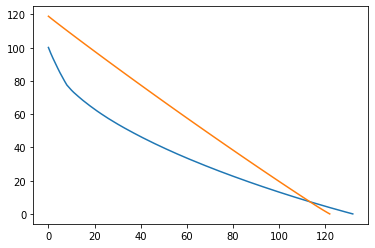

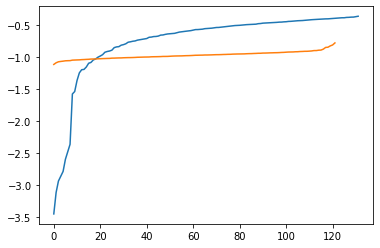

In [27]:
for epoch in range(s.shape[0]):
    selected_s = s[epoch]
    res = []
    for i in range(selected_s.size):
        if i+1 < selected_s.size:
            res.append(selected_s[i+1:].sum())
        else:
            res.append(0)
    
    selected_s = s_rest[epoch]
    res_rest = []
    total_sum = selected_s.sum()
    for i in range(selected_s.size):
        if i+1 < selected_s.size:
            res_rest.append(selected_s[i+1:].sum())
        else:
            res_rest.append(0)
            
    res = np.array(res)
    plt.plot(res)
    res_rest = np.array(res_rest)
    plt.plot(res_rest)
    plt.show()
    plt.plot(res[1:]-res[:-1])
    plt.plot(res_rest[1:]-res_rest[:-1])
    plt.show()

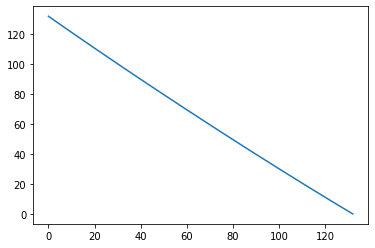

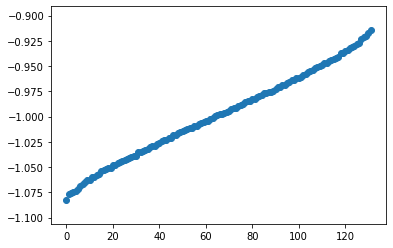

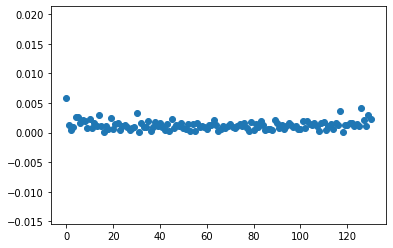

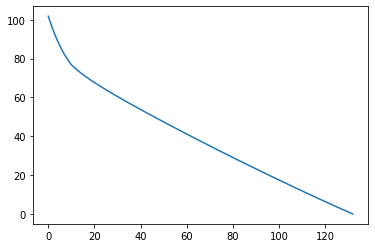

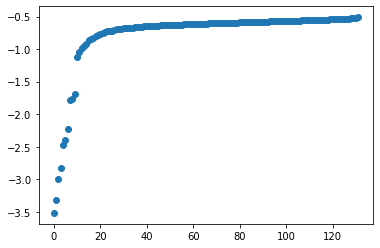

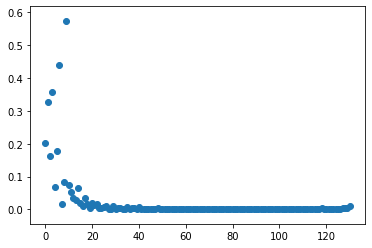

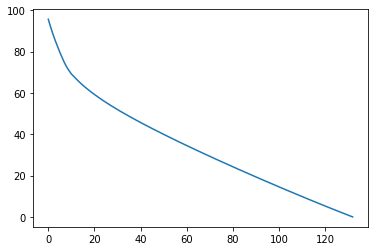

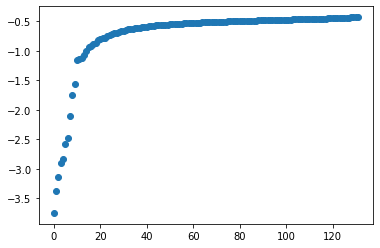

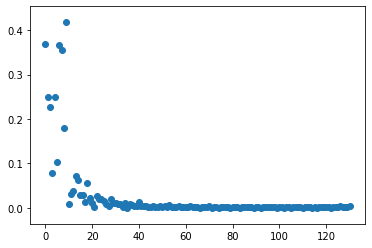

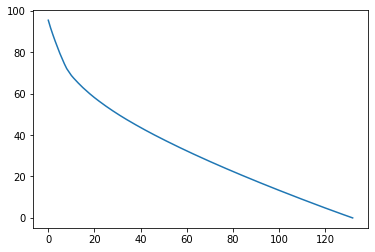

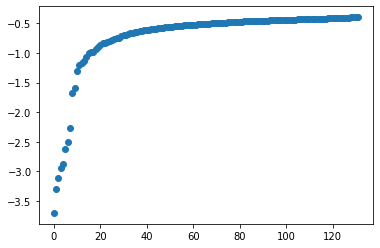

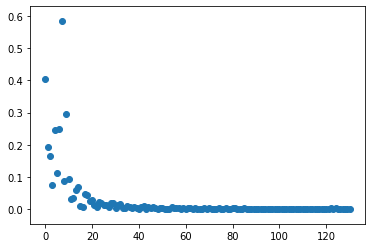

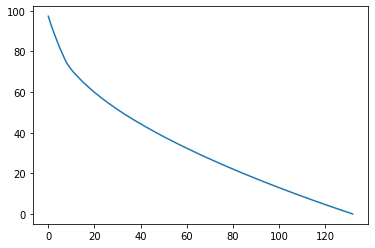

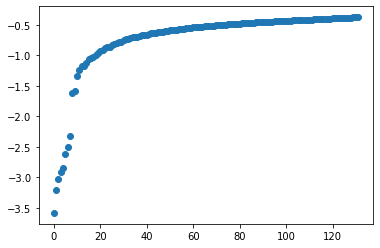

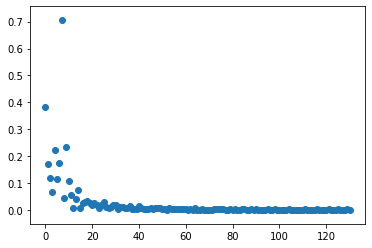

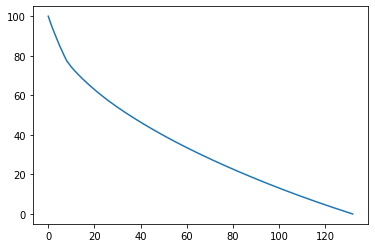

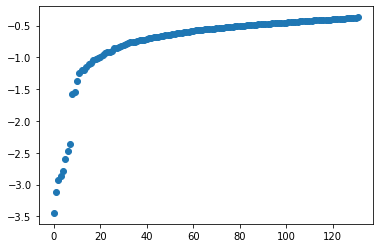

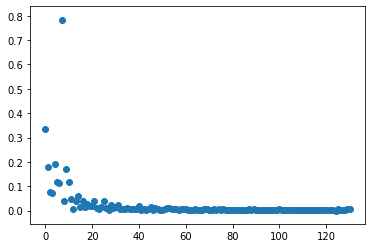

In [43]:
for epoch in range(s.shape[0]):
    selected_s = s[epoch]
    res = []
    for i in range(selected_s.size):
        if i+1 < selected_s.size:
            res.append(selected_s[i+1:].sum())
        else:
            res.append(0)
    res = np.array(res)
    diff1 = res[1:]-res[:-1]
    diff2 = diff1[1:]-diff1[:-1]
    plt.plot(res)
    plt.show()
    plt.scatter(range(len(diff1)), diff1)
    plt.show()
    plt.scatter(range(len(diff2)), diff2)
    plt.show()

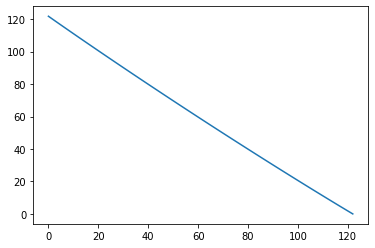

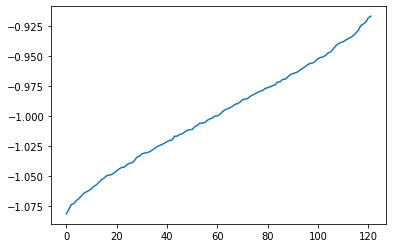

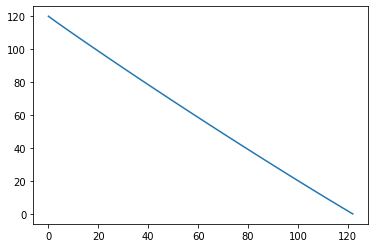

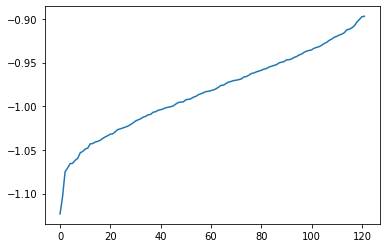

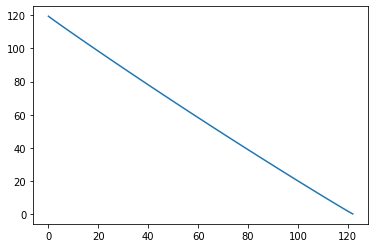

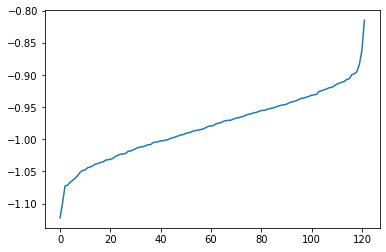

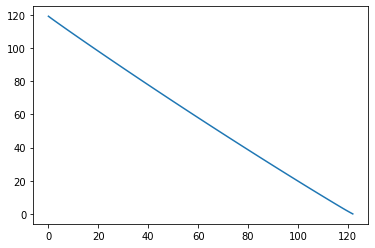

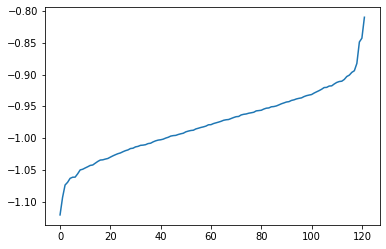

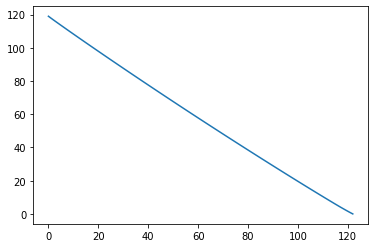

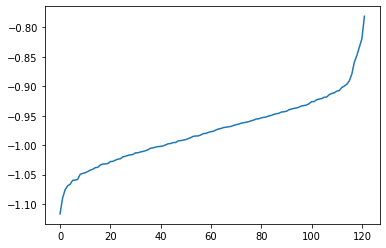

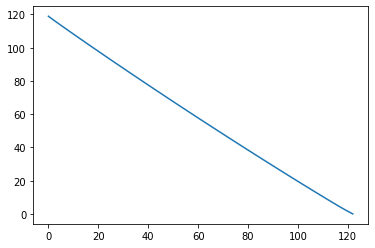

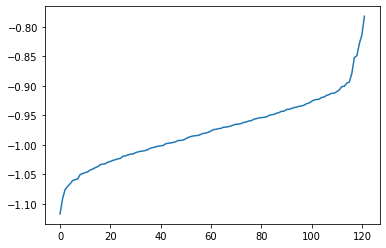

In [42]:
for epoch in range(s_rest.shape[0]):
    selected_s = s_rest[epoch]
    res = []
    for i in range(selected_s.size):
        if i+1 < selected_s.size:
            res.append(selected_s[i+1:].sum())
        else:
            res.append(0)
    res = np.array(res)
    plt.plot(res)
    plt.show()
    plt.plot(res[1:]-res[:-1])
    plt.show()

Number of vectors that contribute most to variance: 66 (correspoinding to 0.9981032013893127)


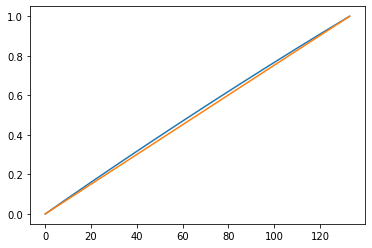

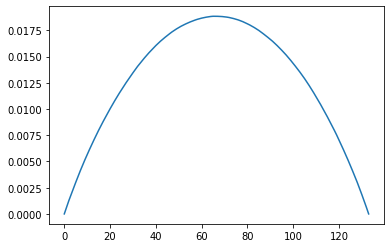

Number of vectors that contribute most to variance: 19 (correspoinding to 0.7930665612220764)


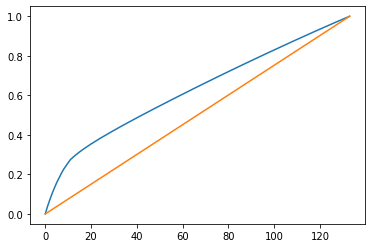

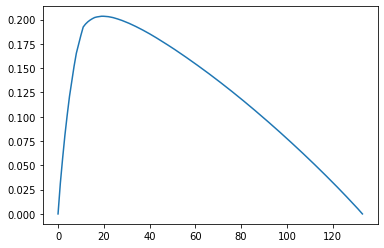

Number of vectors that contribute most to variance: 25 (correspoinding to 0.7363321185112)


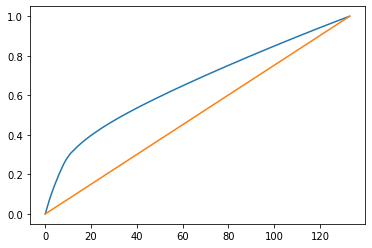

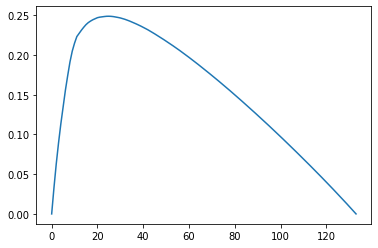

Number of vectors that contribute most to variance: 28 (correspoinding to 0.7449203729629517)


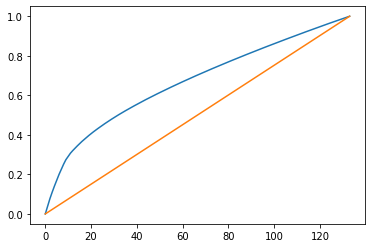

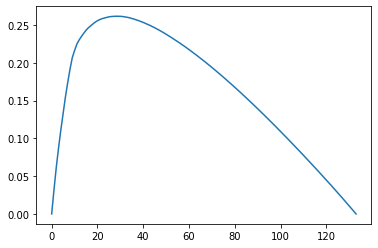

Number of vectors that contribute most to variance: 31 (correspoinding to 0.7571057081222534)


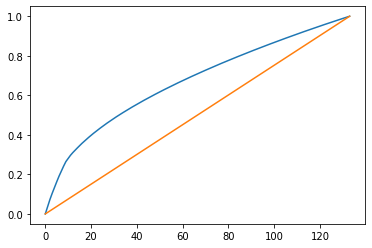

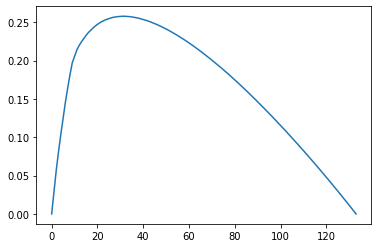

Number of vectors that contribute most to variance: 33 (correspoinding to 0.770538330078125)


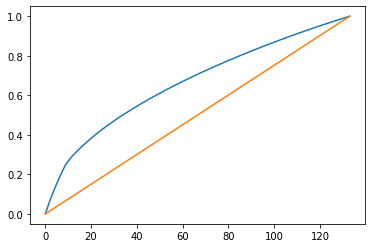

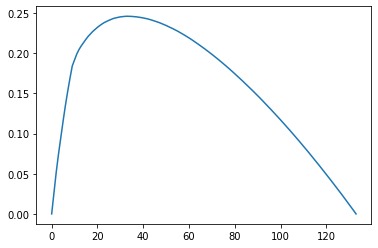

In [64]:
for epoch in range(s.shape[0]):
    selected_s = s[epoch]
    res = [0]
    total_sum = selected_s.sum()
    for i in range(selected_s.size):
        if i+1 < selected_s.size:
            res.append(selected_s[:i+1].sum()/total_sum)
        else:
            res.append(1)
    res = np.array(res)
    lin = np.linspace(0, 1,len(res))
    diff = res - lin
    idx = np.argmax(res-lin)
    print(f"Number of vectors that contribute most to variance: {idx} (correspoinding to {selected_s[idx]})")
    plt.plot(res)
    plt.plot(lin)
    plt.show()
    plt.plot(res-lin)
    plt.show()

In [57]:
u_full = np.zeros((w.shape[0], w.shape[2], w.shape[1]))
s_full = np.zeros((w.shape[0], w.shape[1]))

In [58]:
for epoch in range(w.shape[0]):
    print("Epoch", epoch)
    w_epoch = w[epoch].numpy().T
    u_epoch, s_epoch, _ = np.linalg.svd(w_epoch, full_matrices=False)
    u_full[epoch] = u_epoch
    s_full[epoch] = s_epoch

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


Number of vectors that contribute most to variance: 127 (corresponding to 0.9978413581848145, r = 129)


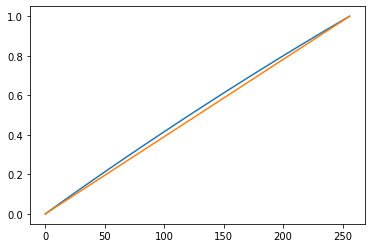

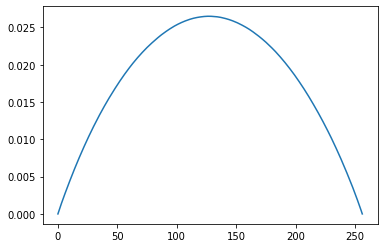

Number of vectors that contribute most to variance: 137 (corresponding to 0.8785960674285889, r = 119)


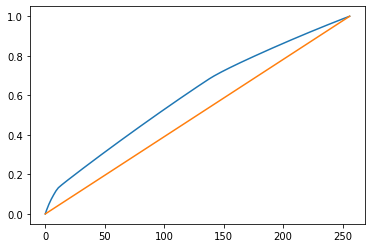

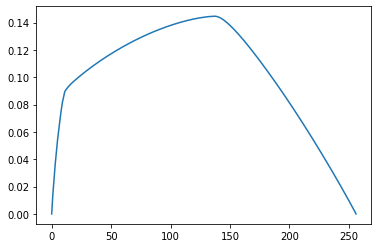

Number of vectors that contribute most to variance: 138 (corresponding to 0.8576788306236267, r = 118)


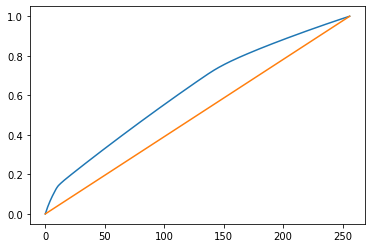

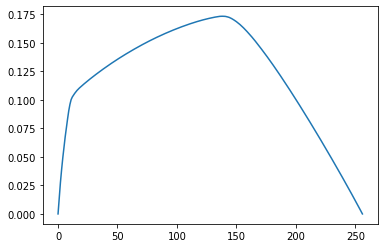

Number of vectors that contribute most to variance: 140 (corresponding to 0.8571061491966248, r = 116)


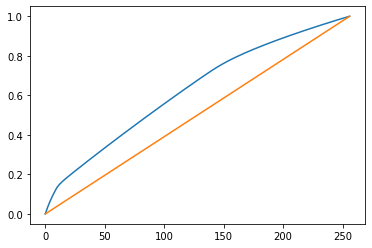

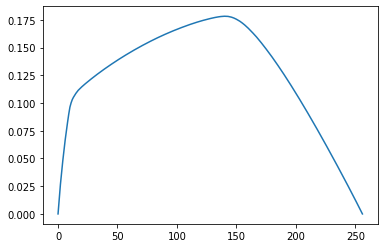

Number of vectors that contribute most to variance: 141 (corresponding to 0.8542609810829163, r = 115)


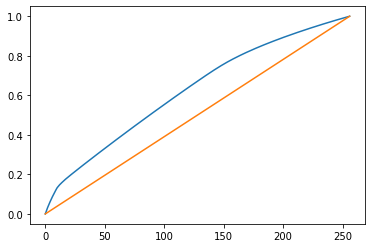

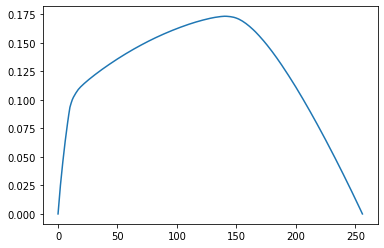

Number of vectors that contribute most to variance: 142 (corresponding to 0.8739621043205261, r = 114)


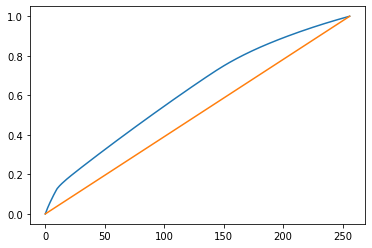

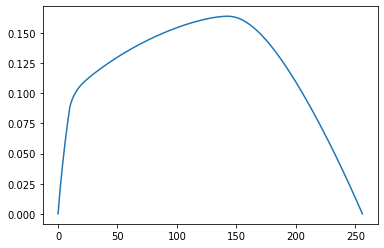

In [95]:
r_vals = []
for epoch in range(s_full.shape[0]):
    selected_s = s_full[epoch]
    res = [0]
    total_sum = selected_s.sum()
    for i in range(selected_s.size):
        if i+1 < selected_s.size:
            res.append(selected_s[:i+1].sum()/total_sum)
        else:
            res.append(1)
    res = np.array(res)
    lin = np.linspace(0, 1,len(res))
    diff = res - lin
    idx = np.argmax(res-lin)
    r = s_full.shape[1] - idx
    r_vals.append(r)
    text = "Number of vectors that contribute most to variance: {} (corresponding to {}, r = {})"
    print(text.format(idx, selected_s[idx], s_full.shape[1] - idx))
    plt.plot(res)
    plt.plot(lin)
    plt.show()
    plt.plot(res-lin)
    plt.show()

Limit: 0.57213104


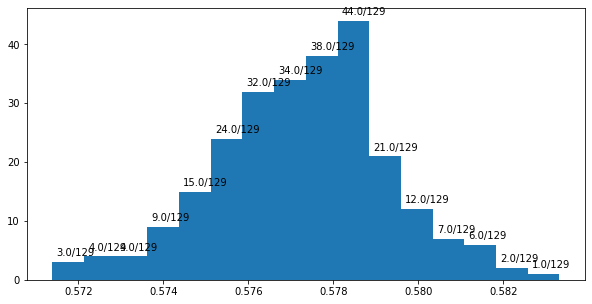

Limit: 0.6217085


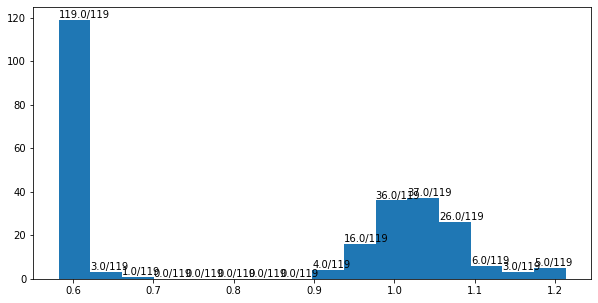

Limit: 0.64697075


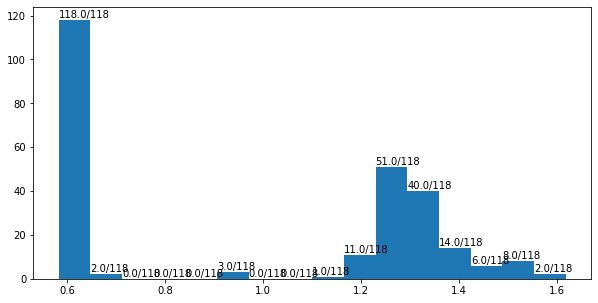

Limit: 0.66814375


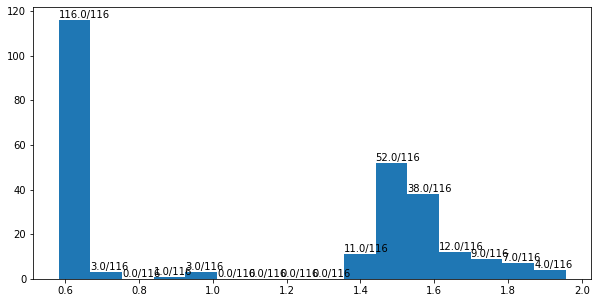

Limit: 0.68655074


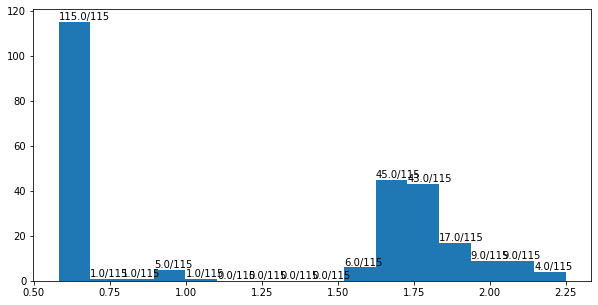

Limit: 0.70223206


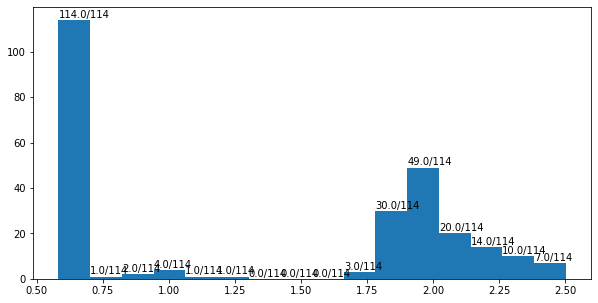

In [109]:
for i in range(epochs):
    plt.figure(figsize=(10,5))
    counts, limits, _ = plt.hist(weight_norms[i], bins=16)
    print("Limit:", limits[1])
    for j, v in enumerate(counts):
        plt.text(x=limits[j]+0.0001, y=v+1, s=f"{v}/{r_vals[i]}", size=10)
    plt.show()

In [98]:
r_vals

[129, 119, 118, 116, 115, 114]

In [113]:
s_full[0]

array([1.12247539, 1.11810684, 1.11754549, 1.11358321, 1.10991704,
       1.10820377, 1.10804534, 1.10592544, 1.10473502, 1.10400939,
       1.10278058, 1.10115302, 1.10079551, 1.09933209, 1.09777319,
       1.09680808, 1.09509337, 1.09334564, 1.09264922, 1.09069419,
       1.09039605, 1.08986843, 1.08795226, 1.08736396, 1.08565295,
       1.08464706, 1.08354795, 1.08247697, 1.08166587, 1.08012867,
       1.0785414 , 1.07783484, 1.07725751, 1.07621038, 1.07477069,
       1.07358909, 1.07245696, 1.07205629, 1.0707705 , 1.06980634,
       1.06861007, 1.067608  , 1.06677628, 1.06489229, 1.06483042,
       1.06376696, 1.06313026, 1.06270647, 1.06216431, 1.06115222,
       1.05975568, 1.05876613, 1.05800009, 1.05744135, 1.05644083,
       1.05561304, 1.05422306, 1.05343986, 1.05287433, 1.05213547,
       1.05145502, 1.04993808, 1.0491668 , 1.04762435, 1.04752386,
       1.04618812, 1.04610515, 1.04447854, 1.04335189, 1.04265809,
       1.04235232, 1.04162836, 1.04051602, 1.04012728, 1.03884

In [110]:
s_full[5]

array([3.51905632, 3.45041323, 3.12293577, 2.9505589 , 2.8610692 ,
       2.79160571, 2.64497066, 2.59841347, 2.46848774, 2.3563211 ,
       1.60916901, 1.53452003, 1.38614523, 1.28917658, 1.25371361,
       1.24393976, 1.20372415, 1.14921451, 1.14195716, 1.11344302,
       1.09813166, 1.09340453, 1.08012342, 1.07693815, 1.06948161,
       1.06649685, 1.05953956, 1.05657125, 1.05548608, 1.05304539,
       1.04913568, 1.04587829, 1.04544365, 1.04297113, 1.04109991,
       1.03779233, 1.03716254, 1.03489578, 1.03419924, 1.03184068,
       1.02972841, 1.02908027, 1.02741539, 1.02534771, 1.02494466,
       1.02379167, 1.02211452, 1.02118504, 1.02052641, 1.019171  ,
       1.0173279 , 1.01503468, 1.01407111, 1.01314151, 1.0110805 ,
       1.00990689, 1.00827098, 1.00755429, 1.00558782, 1.0052067 ,
       1.0036813 , 1.00154197, 1.00127363, 0.99951094, 0.9984082 ,
       0.99683362, 0.99607956, 0.99595499, 0.99428213, 0.99370712,
       0.99232894, 0.99101812, 0.9902972 , 0.98913962, 0.98813

In [112]:
s[5]

array([3.51486349, 3.44765949, 3.11294889, 2.93507862, 2.85840726,
       2.78534961, 2.59588695, 2.47709417, 2.36224651, 1.57787395,
       1.53949308, 1.367643  , 1.2486279 , 1.19964123, 1.19478917,
       1.15699518, 1.09875894, 1.08564568, 1.04742801, 1.03145063,
       1.00454056, 0.98595887, 0.96519554, 0.92696822, 0.91521573,
       0.90793121, 0.8950364 , 0.85517871, 0.84371096, 0.83970523,
       0.81694674, 0.80835301, 0.7949121 , 0.77053833, 0.764103  ,
       0.75554663, 0.75072706, 0.73823041, 0.73204529, 0.72450072,
       0.7188521 , 0.71330088, 0.69400787, 0.69047439, 0.68251485,
       0.6808297 , 0.67471868, 0.659738  , 0.65752017, 0.64834726,
       0.64184034, 0.63910782, 0.6365943 , 0.63210815, 0.62303388,
       0.61295646, 0.60779256, 0.60323107, 0.59862626, 0.5947395 ,
       0.58979297, 0.58145398, 0.57388073, 0.57323569, 0.57016236,
       0.56713402, 0.55937284, 0.55682123, 0.55438966, 0.55149311,
       0.54597735, 0.54104018, 0.54011303, 0.53567266, 0.53089